# 1. Proposal:

## What is the problem you are attempting to solve?
<br> 
I want to see if it makes sense to buy or rent in NY/MA next year. The project goals are to bring visibility into the rental and housing market in NY MA and CT and to shed light on the factors that would impact the decision to buy given projected performance of that investment 5 or 10 years into the future using economic data from the Federal Reserve as well as Zillow data. 
<br>

## How is your solution valuable?
<br>
This problem would impact those that are in a position to buy but are not yet sure if the market has bottomed out and if it makes sense to rent for a bit longer. Given the significance in my own life, these three states are the locations I will be looking at specifically. This product would thus be valuable to anyone that is in a similar position of looking at the east coast and attempting to make a big decision as to where to live and where would bring the most potential (from a location and investment perspective). The inputs that I can take from the user would be things like priorities of surrounding areas like proximity to schools or highways or public transportation.
<br>

## What is your data source and how will you access it?
<br>
Zillow data combined with interest rate/unemployment/inflation data. I already have the datasets I need.  They will be sourced from the below links:
<br>
https://www.zillow.com/research/data/ <br>
https://www.kaggle.com/zillow/zecon <br>
https://www.kaggle.com/federalreserve/interest-rates <br>
<br>
The variables I will be looking at the interest rates data, location and listing information for Massachusetts and New York specifically. I may also be scraping data from google maps for proximity to major cities to get commute times. 
<br>

## What techniques from the course do you anticipate using?

<br>
After EDA, cleaning and feature engineering, I will be using the economics specialization for this project, so I will be relying primarily on linear regression (Probit and Tobit) and robust regression (Huber, Thiel-Sen, and RANSAC) to assume performance gains or losses in 5 or 10 years in the future in buying vs renting scenarios as these long term projections would help with making a decision. I will try all these models and see which performs best. I can use K means clustering to create profiles around particular county profiles that would be most advantageous based on proximity to Boston and NYC, as well as schools, public transport and highways. I can also highlight certain counties or towns as suggestions based on this clustering.
<br>

## What do you anticipate to be the biggest challenge you’ll face?
<br>How to compile it all together and leverage the various data sets in a way that is optimal. Bringing in adequate complexity. Scraping the data I need and getting it to work with my dataframes.
<br>

https://www.zillow.com/research/data/ <br>

https://www.kaggle.com/zillow/zecon <br>

https://www.kaggle.com/federalreserve/interest-rates
<br>



# 2. Ok Lets begin with loading the data, wrangling, cleaning and EDA:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
import re 

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Here I am importing interest rate data from the 50s to today. I am also importing sale prices of homes as well as rental prices of homes, both sets are from Zillow. 

In [2]:
df_interestrates = pd.read_csv('/Users/ir3n3br4t515/Desktop/index.csv')
df_zillowsale = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_State.csv')
df_zillowrent = pd.read_csv('/Users/ir3n3br4t515/Desktop/State_MedianRentalPrice_AllHomes.csv')
df_daysonzillow = pd.read_csv('/Users/ir3n3br4t515/Desktop/DaysOnZillow_State.csv')
df_sale_city = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_City.csv')
df_pricepsqft = pd.read_csv('/Users/ir3n3br4t515/Desktop/State_MedianListingPricePerSqft_AllHomes.csv')
df_saleneighborhood = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_Neighborhood.csv')
df_rent_city = pd.read_csv('/Users/ir3n3br4t515/Desktop/City_Zri_AllHomesPlusMultifamily.csv', encoding='iso-8859-1') 



In [3]:
def transform_date(year, month):
    year = str(year).split(".")[0]
    month = str(month).split(".")[0]
    if len(month)==1:
        month = "0" + month
    return year + "-" + month



In [4]:
df_interestrates["date"] = df_interestrates.apply(lambda x: transform_date(x.Year, x.Month), axis=1)

In [5]:
#I will only be looking at the year, month, unemployment, inflation and effective federal funds rates for each year so i will make a new df.
df_econ = df_interestrates[['date', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
df_econ.head()

,date,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate
0,1954-07,5.8,NaN,0.80
1,1954-08,6.0,NaN,1.22
2,1954-09,6.1,NaN,1.06
3,1954-10,5.7,NaN,0.85
4,1954-11,5.3,NaN,0.83


In [6]:
df_econ = df_econ.set_index("date")

### Below I am creating new dfs for our rent and sale data so that we are looking only at MA, NY as these are the three states we are interested in based on the proposal. 

### The rental market is first 

In [7]:
df_rent = df_zillowrent.iloc[[2, 13]]

df_rent.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
2,New York,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3150,3100,3195.0,3200.0,3490,3295,3260,3200,3375.0,3234.0
13,Massachusetts,14,NaN,NaN,1552.5,1675.0,1552.5,1775.0,1550.0,1600.0,...,2500,2550,2600.0,2699.0,2700,2700,2700,2695,2599.0,2500.0


In [8]:
df_rent = df_rent.T
df_rent.columns = ["NY_R", "MA_R"]

In [9]:
df_rent = df_rent.drop("RegionName", axis=0)
df_rent = df_rent.drop("SizeRank", axis=0)

In [10]:
df_rent.head()

,NY_R,MA_R
2010-01,NaN,NaN
2010-02,NaN,NaN
2010-03,NaN,1552.5
2010-04,NaN,1675
2010-05,NaN,1552.5


### Sale market is second 

In [11]:
df_sale = df_zillowsale.iloc[[1, 12]]
df_sale.head(100)

,RegionID,RegionName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
1,43,New York,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,291200,297800,297400,294700,292600.0,296500.0,306300.0,311100.0,314400.0,NaN
12,26,Massachusetts,13,314500.0,309500.0,297400.0,291300.0,287900.0,288200.0,285400.0,...,368000,368500,378400,388000,390200.0,384100.0,383300.0,385800.0,385600.0,NaN


In [12]:
df_sale = df_sale.T
df_sale.columns = ["NY_S", "MA_S"]

In [13]:
df_sale.head(100)

,NY_S,MA_S
RegionID,43,26
RegionName,New York,Massachusetts
SizeRank,2,13
2008-03,NaN,314500
2008-04,NaN,309500
...,...,...
2015-11,238600,325500
2015-12,239000,327600
2016-01,236900,327100
2016-02,233400,328600


### Days on Zillow data is third 

In [14]:
df_daysonzillow.head(100)

,SizeRank,RegionID,RegionName,RegionType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,1.0,9,California,State,109.0,115.0,107.0,103.0,89.0,91.0,...,73.0,83.0,82.0,62.0,58.0,56.0,57.0,60.0,62.0,64
1,2.0,54,Texas,State,121.0,124.0,122.0,112.0,98.0,100.0,...,82.0,88.0,88.0,73.0,66.0,63.0,63.0,63.0,66.0,73
2,3.0,43,New York,State,189.0,193.0,192.0,185.0,180.0,135.0,...,128.0,140.0,145.0,150.0,145.0,119.0,112.0,112.0,113.0,120
3,4.0,14,Florida,State,163.0,157.0,155.0,158.0,152.0,131.0,...,88.0,95.0,100.0,95.0,87.0,87.0,86.0,85.0,84.0,85
4,5.0,21,Illinois,State,174.0,177.0,178.0,181.0,161.0,129.0,...,105.0,116.0,126.0,121.0,83.0,75.0,76.0,80.0,83.0,88
5,6.0,47,Pennsylvania,State,137.0,150.0,151.0,152.0,122.0,112.0,...,89.0,98.0,107.0,104.0,83.0,73.0,72.0,73.0,75.0,77
6,7.0,44,Ohio,State,143.0,153.0,153.0,152.0,124.0,110.0,...,78.0,88.0,96.0,81.0,66.0,60.0,59.0,61.0,62.0,63
7,8.0,30,Michigan,State,135.0,140.0,140.0,143.0,125.0,115.0,...,81.0,91.0,95.0,92.0,72.0,62.0,61.0,63.0,66.0,70
8,9.0,16,Georgia,State,158.0,164.0,161.0,160.0,152.0,126.0,...,81.0,89.0,89.0,67.0,68.0,64.0,64.0,67.0,69.0,73
9,10.0,36,North Carolina,State,172.0,170.0,167.0,175.0,141.0,126.0,...,82.0,91.0,92.0,72.0,63.0,61.0,63.0,63.0,67.0,70


In [15]:
df_dayszillow = df_daysonzillow.iloc[[2, 13]]
df_dayszillow.head()

,SizeRank,RegionID,RegionName,RegionType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
2,3.0,43,New York,State,189.0,193.0,192.0,185.0,180.0,135.0,...,128.0,140.0,145.0,150.0,145.0,119.0,112.0,112.0,113.0,120
13,14.0,26,Massachusetts,State,149.0,157.0,153.0,153.0,118.0,110.0,...,79.0,93.0,105.0,84.0,70.0,67.0,66.0,69.0,72.0,77


In [16]:
df_dayszillow = df_dayszillow.T
df_dayszillow.columns = ["NY_days", "MA_days"]

In [17]:
df_dayszillow = df_dayszillow.drop("RegionName", axis=0)
df_dayszillow = df_dayszillow.drop("RegionID", axis=0)
df_dayszillow = df_dayszillow.drop("SizeRank", axis=0)

In [18]:
df_dayszillow.head()

,NY_days,MA_days
RegionType,State,State
2010-01,189,149
2010-02,193,157
2010-03,192,153
2010-04,185,153


### Price Per Sq Ft is fourth. 

In [19]:
df_pricepsqft.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,California,1,210.117014,213.913415,215.515176,218.470343,219.435737,219.593665,216.994638,215.915617,...,308.848080,314.343087,320.359281,325.009560,323.809524,324.306252,323.155894,321.212121,322.713308,323.105102
1,Texas,2,85.757867,86.131934,86.633663,86.944938,86.935406,86.698795,85.991245,85.588467,...,126.404743,127.062333,128.057091,129.592471,129.731514,130.081301,129.933397,129.761481,129.986245,129.841549
2,New York,3,180.250784,175.585284,177.476852,176.430518,186.623514,187.713956,188.235294,184.601113,...,197.722052,202.093589,206.700644,209.821429,204.865235,200.806452,194.529906,191.250000,193.421053,194.348928
3,Florida,4,119.438669,118.257963,116.842517,115.427233,114.443349,112.030075,110.347461,109.138906,...,166.242617,166.666667,165.797788,167.178477,166.223618,166.216755,166.349810,166.527662,166.286496,165.833333
4,Illinois,5,137.610619,137.273902,137.751856,137.502866,136.274510,135.099462,131.513158,130.655894,...,147.523709,150.706155,153.802198,156.339286,155.097518,154.700222,153.086420,150.796312,149.966674,149.046105


In [20]:
df_ppsqft = df_pricepsqft.iloc[[2, 13]]
df_ppsqft.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
2,New York,3,180.250784,175.585284,177.476852,176.430518,186.623514,187.713956,188.235294,184.601113,...,197.722052,202.093589,206.700644,209.821429,204.865235,200.806452,194.529906,191.25000,193.421053,194.348928
13,Massachusetts,14,202.110390,202.631579,203.061224,203.533139,203.660089,202.104146,200.089127,197.967086,...,251.877682,255.712528,261.964736,268.120605,270.356234,270.270270,267.461089,264.73029,268.493582,268.352060


In [21]:
df_ppsqft = df_ppsqft.T

In [22]:
df_ppsqft.columns = ["NY_SqF", "MA_SqF"]

In [23]:
df_ppsqft = df_ppsqft.drop("RegionName", axis=0)
df_ppsqft = df_ppsqft.drop("SizeRank", axis=0)

In [24]:
df_ppsqft.head()

,NY_SqF,MA_SqF
2010-01,180.251,202.11
2010-02,175.585,202.632
2010-03,177.477,203.061
2010-04,176.431,203.533
2010-05,186.624,203.66


### Sale and rental market by city is fifth:

In [25]:
df_sale_city.head(100)

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,556900.0,564200.0,562500.0,576400.0,560600.0,561700.0,566300.0,567000.0,563800.0,554900.0
1,12447,Los Angeles,California,2,506200.0,487600.0,463200.0,453900.0,438700.0,423500.0,...,682200.0,685400.0,701200.0,699900.0,701100.0,703700.0,708900.0,713700.0,710300.0,709900.0
2,39051,Houston,Texas,3,138400.0,134700.0,131200.0,129600.0,132000.0,134000.0,...,210500.0,206500.0,207700.0,206300.0,210700.0,211600.0,210300.0,209900.0,207000.0,212100.0
3,17426,Chicago,Illinois,4,329700.0,320400.0,295600.0,276600.0,269400.0,265900.0,...,255600.0,266500.0,299900.0,298300.0,287600.0,277700.0,275400.0,272800.0,270600.0,266200.0
4,6915,San Antonio,Texas,5,130300.0,131300.0,131300.0,131700.0,131700.0,132600.0,...,190500.0,189500.0,191100.0,193600.0,196500.0,197600.0,199400.0,201100.0,201600.0,204400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6210,Norfolk,Virginia,96,NaN,NaN,NaN,NaN,NaN,NaN,...,188800.0,189500.0,193900.0,199300.0,201400.0,195000.0,198200.0,197700.0,202900.0,NaN
96,18298,Glendale,Arizona,97,215700.0,210800.0,200000.0,187400.0,178600.0,172700.0,...,214000.0,222600.0,225100.0,222600.0,223900.0,226600.0,232800.0,236400.0,237200.0,239100.0
97,54346,Scottsdale,Arizona,98,411700.0,374400.0,358200.0,373500.0,373600.0,366400.0,...,374100.0,362600.0,360800.0,350700.0,359800.0,368000.0,374900.0,379300.0,381300.0,395700.0
98,52001,Fayetteville,North Carolina,99,NaN,NaN,NaN,NaN,NaN,NaN,...,114500.0,118800.0,120200.0,115500.0,120500.0,122700.0,123200.0,118100.0,115400.0,120400.0


In [26]:
df_sale_city = df_sale_city.iloc[[0, 25]]
df_sale_city.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,556900.0,564200.0,562500.0,576400.0,560600.0,561700.0,566300.0,567000.0,563800.0,554900.0
25,44269,Boston,Massachusetts,26,NaN,NaN,NaN,NaN,NaN,NaN,...,631800.0,636900.0,636200.0,642500.0,635300.0,638600.0,654500.0,650900.0,651800.0,640600.0


In [27]:
df_sale_city = df_sale_city.T
df_sale_city.head()

,0,25
RegionID,6181,44269
RegionName,New York,Boston
StateName,New York,Massachusetts
SizeRank,1,26
2008-03,NaN,NaN


In [28]:
df_sale_city.columns = ["NYC_S", "Boston_S"]

In [29]:
df_sale_city = df_sale_city.drop("RegionName", axis=0)
df_sale_city = df_sale_city.drop("SizeRank", axis=0)

In [30]:
df_sale_city.head()

,NYC_S,Boston_S
RegionID,6181,44269
StateName,New York,Massachusetts
2008-03,NaN,NaN
2008-04,NaN,NaN
2008-05,NaN,NaN


In [31]:
df_rent_city.head(30)

,RegionID,RegionName,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,NY,New York-Newark-Jersey City,Queens County,1,1668.64,1686.88,1695.90,1698.04,...,2335.91,2338.80,2337.10,2334.53,2335.58,2340.38,2347.71,2356.57,2364.41,2389.72
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2299.35,2294.56,2278.90,2264.58,...,2766.31,2771.07,2772.12,2774.41,2779.58,2784.36,2789.79,2798.82,2808.80,2829.38
2,39051,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1146.50,1129.59,1118.61,1104.30,...,1385.64,1377.81,1370.67,1365.64,1363.81,1365.22,1367.52,1370.13,1372.28,1379.67
3,17426,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1451.26,1469.49,1476.78,1478.36,...,1662.78,1656.28,1657.96,1665.92,1678.64,1690.81,1704.77,1717.77,1723.41,1706.01
4,6915,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,945.33,951.84,952.41,957.07,...,1191.42,1186.40,1183.94,1183.81,1185.41,1190.01,1193.89,1195.83,1195.33,1201.35
5,13271,Philadelphia,PA,Philadelphia-Camden-Wilmington,Philadelphia County,6,1163.29,1166.84,1162.44,1154.33,...,1304.69,1296.95,1295.26,1298.63,1305.87,1317.62,1331.33,1343.25,1349.54,1356.02
6,40326,Phoenix,AZ,Phoenix-Mesa-Scottsdale,Maricopa County,7,1061.42,1047.57,1039.98,1035.02,...,1319.84,1319.67,1321.02,1324.69,1332.11,1343.31,1356.67,1369.64,1380.93,1405.60
7,18959,Las Vegas,NV,Las Vegas-Henderson-Paradise,Clark County,8,1086.28,1099.50,1106.33,1112.41,...,1292.39,1288.63,1288.84,1293.43,1303.71,1315.33,1326.89,1336.80,1344.36,1363.84
8,54296,San Diego,CA,San Diego-Carlsbad,San Diego County,9,2046.29,2049.13,2053.78,2053.32,...,2503.04,2500.31,2497.43,2496.67,2522.07,2543.06,2562.53,2577.79,2587.61,2605.51
9,38128,Dallas,TX,Dallas-Fort Worth-Arlington,Dallas County,10,1071.62,1083.90,1100.89,1114.93,...,1466.07,1461.62,1460.16,1461.50,1464.97,1469.86,1475.49,1479.81,1482.47,1485.58


In [32]:
df_rent_city = df_rent_city.iloc[[0, 26]]
df_rent_city.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,NY,New York-Newark-Jersey City,Queens County,1,1668.64,1686.88,1695.90,1698.04,...,2335.91,2338.80,2337.10,2334.53,2335.58,2340.38,2347.71,2356.57,2364.41,2389.72
26,44269,Boston,MA,Boston-Cambridge-Newton,Suffolk County,27,1857.87,1824.65,1802.43,1787.04,...,2613.16,2645.36,2692.03,2741.00,2775.20,2802.24,2825.61,2839.28,2844.36,2850.52


In [33]:
df_rent_city = df_rent_city.T
df_rent_city.head()

,0,26
RegionID,6181,44269
RegionName,New York,Boston
State,NY,MA
Metro,New York-Newark-Jersey City,Boston-Cambridge-Newton
CountyName,Queens County,Suffolk County


In [34]:
df_rent_city.columns = ["NYC_R", "Boston_R"]

In [35]:
df_rent_city.head(10)

,NYC_R,Boston_R
RegionID,6181,44269
RegionName,New York,Boston
State,NY,MA
Metro,New York-Newark-Jersey City,Boston-Cambridge-Newton
CountyName,Queens County,Suffolk County
SizeRank,1,27
2010-09,1668.64,1857.87
2010-10,1686.88,1824.65
2010-11,1695.9,1802.43
2010-12,1698.04,1787.04


### Done! Now we can combine them. 

In [36]:
df_combined = df_econ.merge(df_sale, left_index=True, right_index=True)

In [37]:
df_combined = df_combined.merge(df_rent, left_index=True, right_index=True)

In [38]:
df_combined = df_combined.merge(df_ppsqft, left_index=True, right_index=True)

In [39]:
df_combined = df_combined.merge(df_dayszillow, left_index=True, right_index=True)

In [40]:
df_combined = df_combined.merge(df_sale_city, left_index=True, right_index=True)

In [41]:
df_combined = df_combined.merge(df_rent_city, left_index=True, right_index=True)

In [42]:
df_combined.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
2010-09,9.5,0.8,0.19,NaN,289800,NaN,1650,187.778,196.863,145,117,NaN,NaN,1668.64,1857.87
2010-10,9.4,0.6,0.19,NaN,287900,NaN,1680,187.496,195.878,151,128,NaN,NaN,1686.88,1824.65
2010-11,9.8,0.8,0.19,NaN,285200,NaN,1700,187.798,195.076,155,118,NaN,NaN,1695.9,1802.43
2010-12,9.3,0.8,0.18,241400,283900,NaN,1800,185.95,191.388,157,118,457600,NaN,1698.04,1787.04
2011-01,9.1,1.0,0.17,245600,275000,NaN,1800,185.571,189.738,172,130,462800,NaN,1687.8,1809.4


### Let's see how much of our data we are missing!

In [43]:
df_combined.isnull().sum()*100/df_combined.count()


Unemployment Rate                5.128205
Inflation Rate                   5.128205
Effective Federal Funds Rate     5.128205
NY_S                             3.797468
MA_S                             0.000000
NY_R                             7.894737
MA_R                             0.000000
NY_SqF                           0.000000
MA_SqF                           0.000000
NY_days                          0.000000
MA_days                          0.000000
NYC_S                            3.797468
Boston_S                        34.426230
NYC_R                            1.234568
Boston_R                         1.234568
dtype: float64

In [44]:
df_final = df_combined.fillna(df_combined.mean())

In [45]:
df_final.isnull().sum()*100/df_final.count()


Unemployment Rate               0.0
Inflation Rate                  0.0
Effective Federal Funds Rate    0.0
NY_S                            0.0
MA_S                            0.0
NY_R                            0.0
MA_R                            0.0
NY_SqF                          0.0
MA_SqF                          0.0
NY_days                         0.0
MA_days                         0.0
NYC_S                           0.0
Boston_S                        0.0
NYC_R                           0.0
Boston_R                        0.0
dtype: float64

In [46]:
df_final.shape

(82, 15)

In [47]:
df_final.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
2010-09,9.5,0.8,0.19,230164.556962,289800.0,2957.815789,1650.0,187.777778,196.862976,145.0,117.0,497241.772152,466878.688525,1668.64,1857.87
2010-10,9.4,0.6,0.19,230164.556962,287900.0,2957.815789,1680.0,187.495833,195.877551,151.0,128.0,497241.772152,466878.688525,1686.88,1824.65
2010-11,9.8,0.8,0.19,230164.556962,285200.0,2957.815789,1700.0,187.798054,195.075758,155.0,118.0,497241.772152,466878.688525,1695.90,1802.43
2010-12,9.3,0.8,0.18,241400.000000,283900.0,2957.815789,1800.0,185.950413,191.387770,157.0,118.0,457600.000000,466878.688525,1698.04,1787.04
2011-01,9.1,1.0,0.17,245600.000000,275000.0,2957.815789,1800.0,185.571429,189.738249,172.0,130.0,462800.000000,466878.688525,1687.80,1809.40


### Ok we have filled in our nulls with averages so as not to disrupt our data or lose our rows of missing values. 

### Next let's take a look at our outliers and remove those that are more than 2 standard deviations. 

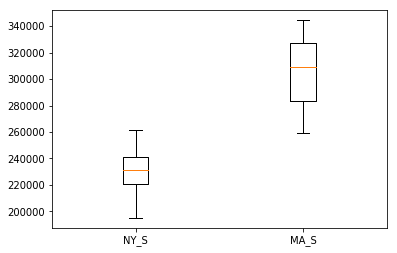

In [48]:
plt.boxplot([df_final.NY_S, df_final.MA_S])
plt.xticks([1,2], ['NY_S','MA_S'])
plt.show()

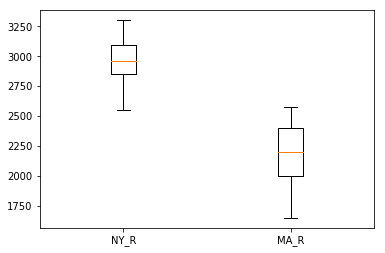

In [49]:
plt.boxplot([df_final.NY_R, df_final.MA_R])
plt.xticks([1,2], ['NY_R','MA_R'])
plt.show()

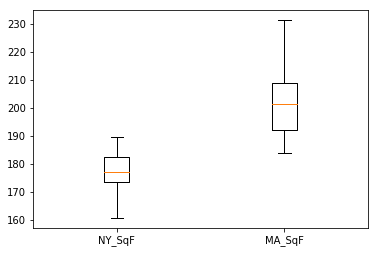

In [50]:
plt.boxplot([df_final.NY_SqF, df_final.MA_SqF])
plt.xticks([1,2], ['NY_SqF','MA_SqF'])
plt.show()

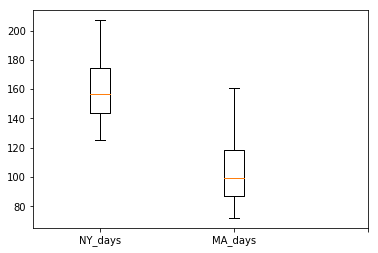

In [51]:
plt.boxplot([df_final.NY_days, df_final.MA_days])
plt.xticks([1,2,3], ['NY_days','MA_days'])
plt.show()

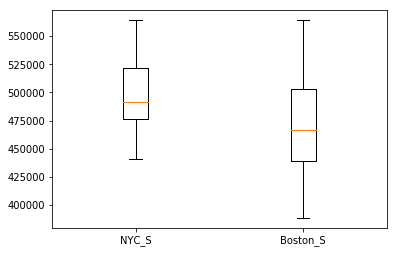

In [52]:
plt.boxplot([df_final.NYC_S, df_final.Boston_S])
plt.xticks([1,2], ['NYC_S','Boston_S'])
plt.show()

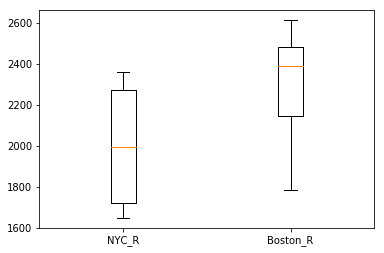

In [53]:
plt.boxplot([df_final.NYC_R, df_final.Boston_R])
plt.xticks([1,2], ['NYC_R','Boston_R'])
plt.show()

### And some EDA

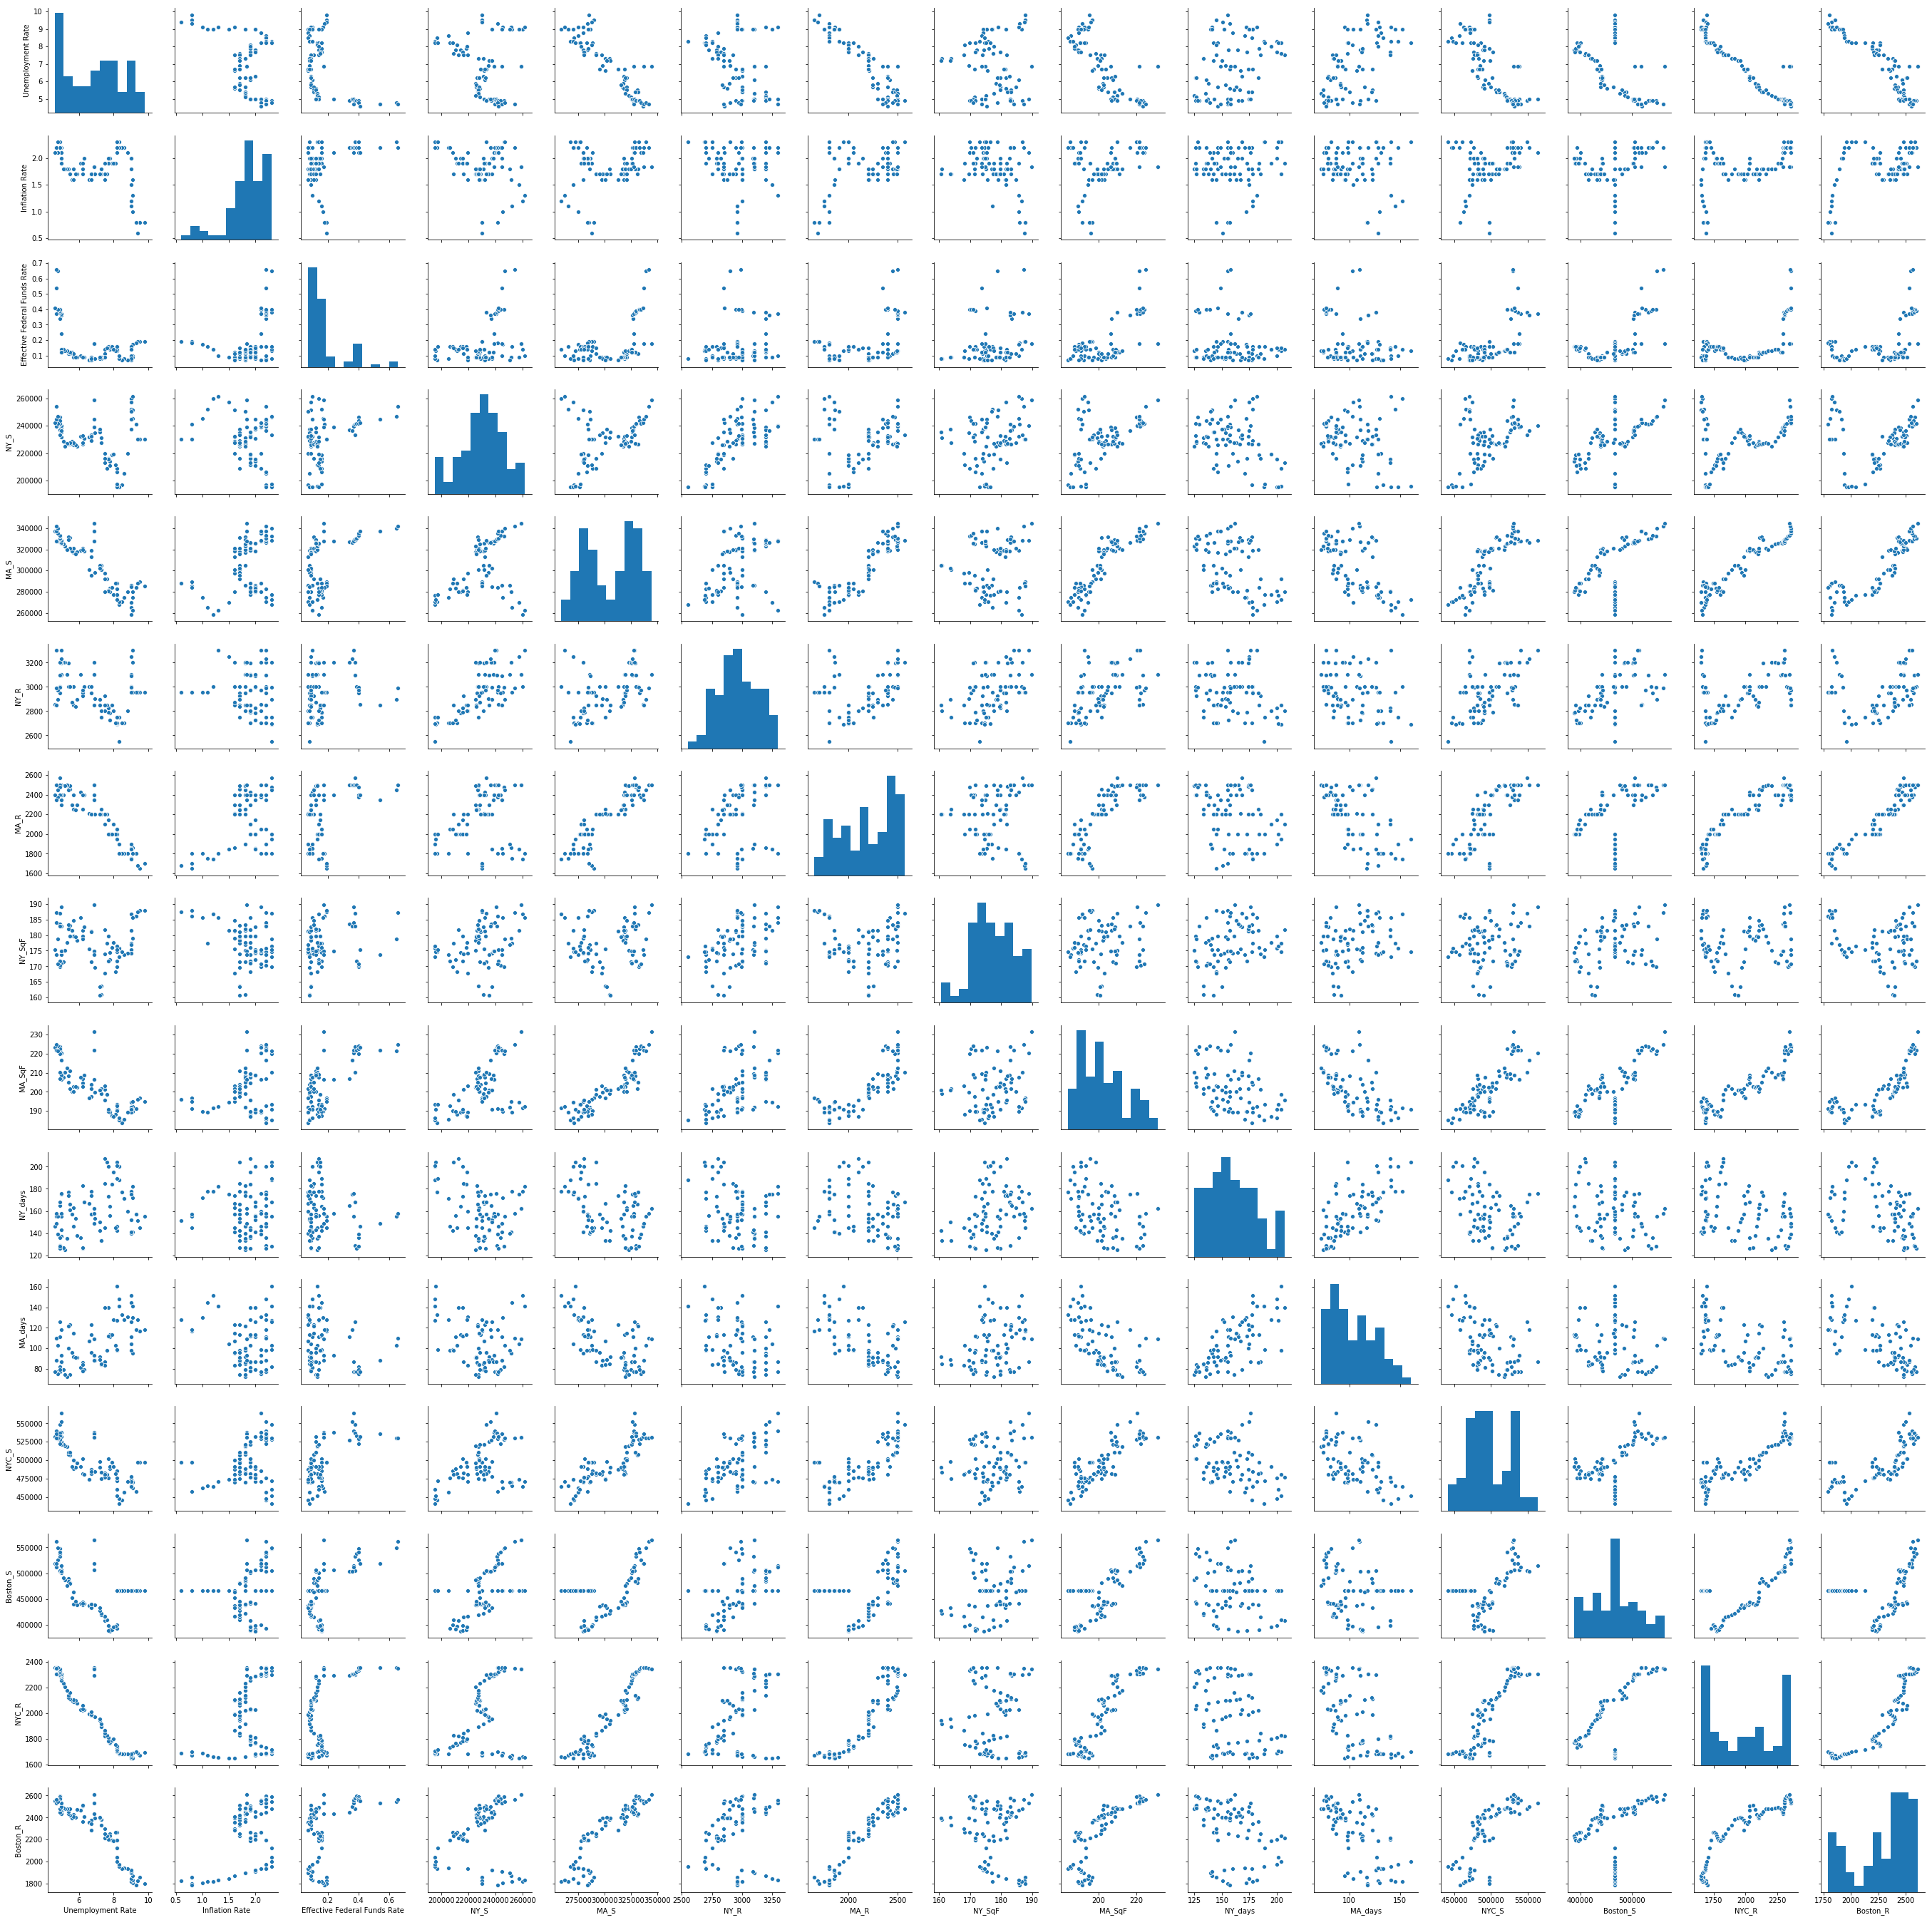

In [54]:
sns.pairplot(df_final, size=2.5);



In [55]:
df_final.describe()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,6.862821,1.835897,0.175000,230164.556962,305284.146341,2957.815789,2189.920732,177.459070,202.679372,159.524390,104.018293,497241.772152,466878.688525,1988.812593,2286.367037
std,1.567266,0.370510,0.129584,16100.839929,24098.693523,170.755381,262.012763,6.599151,12.106396,21.026864,21.732158,28010.983770,44732.988669,255.688948,253.994432
min,4.600000,0.600000,0.070000,195000.000000,258900.000000,2550.000000,1650.000000,160.656535,183.888889,125.000000,72.000000,440700.000000,388400.000000,1648.890000,1787.040000
25%,5.325000,1.700000,0.090000,220900.000000,283600.000000,2850.000000,2000.000000,173.677579,192.212702,143.500000,87.000000,476450.000000,438700.000000,1719.930000,2143.650000
50%,6.862821,1.867949,0.130000,231100.000000,309000.000000,2957.815789,2204.500000,177.150933,201.405712,157.000000,99.000000,491150.000000,466878.688525,1992.236296,2387.795000
75%,8.200000,2.100000,0.175000,240925.000000,326975.000000,3095.000000,2400.000000,182.482252,208.986638,174.750000,118.375000,521800.000000,502775.000000,2272.137500,2481.315000
max,9.800000,2.300000,0.660000,261700.000000,344400.000000,3300.000000,2575.000000,189.710706,231.395797,207.000000,161.000000,564000.000000,564100.000000,2358.660000,2610.660000


In [56]:
df_final.corr()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
Unemployment Rate,1.000000,-0.465729,-0.513815,-0.223187,-0.885364,-0.382878,-0.927932,-0.006802,-0.784115,0.331988,0.594896,-0.777566,-0.506823,-0.932145,-0.911488
Inflation Rate,-0.465729,1.000000,0.351506,-0.293638,0.282366,-0.147310,0.441984,-0.318181,0.273631,0.043859,-0.167989,0.260092,0.224328,0.371492,0.470482
Effective Federal Funds Rate,-0.513815,0.351506,1.000000,0.355007,0.496549,0.198507,0.413851,0.175786,0.637688,-0.151062,-0.177756,0.642981,0.632150,0.577823,0.406775
NY_S,-0.223187,-0.293638,0.355007,1.000000,0.410782,0.689220,0.246417,0.308870,0.538764,-0.387103,-0.241601,0.460377,0.558031,0.410769,0.184704
MA_S,-0.885364,0.282366,0.496549,0.410782,1.000000,0.450183,0.904747,0.132261,0.902262,-0.457423,-0.629973,0.846443,0.630835,0.956817,0.891185
NY_R,-0.382878,-0.147310,0.198507,0.689220,0.450183,1.000000,0.417331,0.443796,0.479850,-0.238987,-0.284658,0.567690,0.510151,0.463671,0.252002
MA_R,-0.927932,0.441984,0.413851,0.246417,0.904747,0.417331,1.000000,0.040824,0.815870,-0.314411,-0.625861,0.778611,0.456233,0.917252,0.954609
NY_SqF,-0.006802,-0.318181,0.175786,0.308870,0.132261,0.443796,0.040824,1.000000,0.186700,0.291786,0.303988,0.169506,0.311981,0.086093,-0.112791
MA_SqF,-0.784115,0.273631,0.637688,0.538764,0.902262,0.479850,0.815870,0.186700,1.000000,-0.395034,-0.594472,0.839254,0.755522,0.912083,0.801234
NY_days,0.331988,0.043859,-0.151062,-0.387103,-0.457423,-0.238987,-0.314411,0.291786,-0.395034,1.000000,0.696856,-0.388176,-0.246556,-0.379635,-0.385240


### Let's take a look at the distribution of each of our variables which we've already selected prior because we knew we wanted to focus on MA and NY for all these data points.

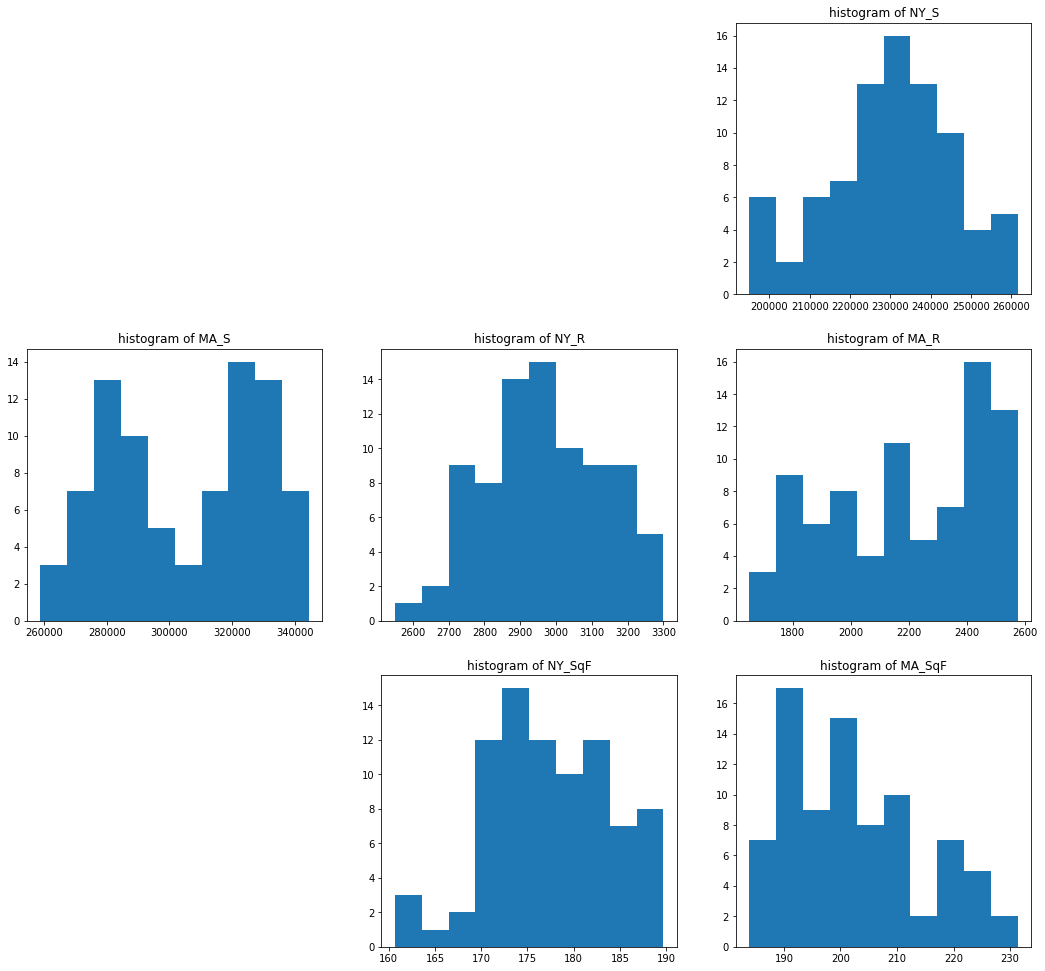

In [57]:
plt.figure(figsize=(18,17))

# histograms of the original data

plt.subplot(3, 3, 3)
plt.hist(df_final["NY_S"])
plt.title("histogram of NY_S")

plt.subplot(3, 3, 4)
plt.hist(df_final["MA_S"])
plt.title("histogram of MA_S")

plt.subplot(3, 3, 5)
plt.hist(df_final["NY_R"])
plt.title("histogram of NY_R")

plt.subplot(3, 3, 6)
plt.hist(df_final["MA_R"])
plt.title("histogram of MA_R")

plt.subplot(3, 3, 8)
plt.hist(df_final["NY_SqF"])
plt.title("histogram of NY_SqF")

plt.subplot(3, 3, 9)
plt.hist(df_final["MA_SqF"])
plt.title("histogram of MA_SqF")

plt.show()

Text(0.5, 1.0, 'histogram of Boston_R')

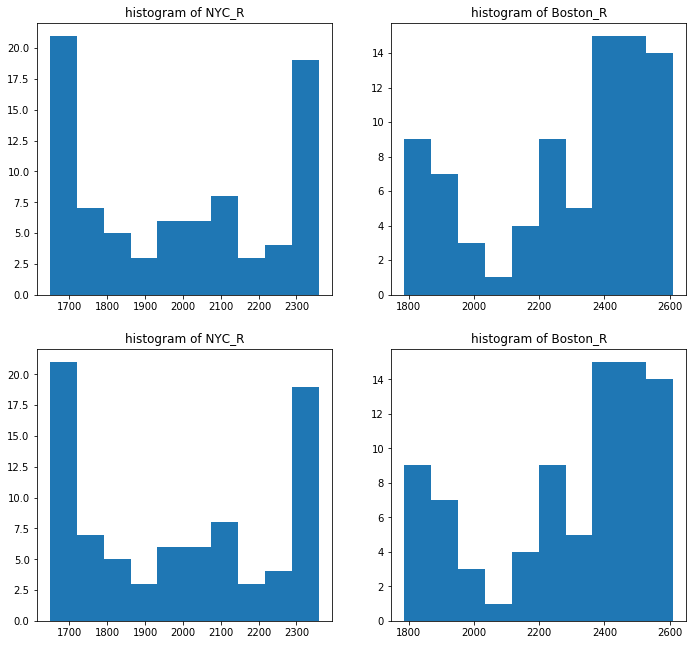

In [58]:
plt.figure(figsize=(18,17))

plt.subplot(3, 3, 5)
plt.hist(df_final["NYC_R"])
plt.title("histogram of NYC_R")

plt.subplot(3, 3, 6)
plt.hist(df_final["Boston_R"])
plt.title("histogram of Boston_R")

plt.subplot(3, 3, 8)
plt.hist(df_final["NYC_R"])
plt.title("histogram of NYC_R")

plt.subplot(3, 3, 9)
plt.hist(df_final["Boston_R"])
plt.title("histogram of Boston_R")

# 3. Supervised Modeling! 

## We have looked over out data, normalized it, accounted for ouliers and created a DF with exactly the variables we want to isolate. Because I knew which features I wanted to include in my model, this made feature selection easy. 

## Let's put those features to work for us by loading them into a regression model. This will be the supervised portion of this project where we will use regression to better help us with predicting NYC and Boston sale prices for us in the future. 

### Let's start with OLS to get a baseline regression going to predict NYC Sale prices since that's where I currently live, and then move on to Boston: 



## OLS 

### Sale Regression for NYC and Boston

In [59]:
#I am not able to use gridsearch for OLS. Let's see if I can use it with Huber Regression.

In [60]:

import warnings
warnings.filterwarnings(action="ignore")

#regularization 



X = df_final[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days']] 
Y = df_final['NYC_S']

#(X, y, alpha = 0, lambda = lambda_cv, standardize = TRUE)




X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
print('score: ' + str(lrm.score(X,Y)))

The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.8139725097046037
-----Test set statistics-----
R-squared of the model in the test set is: 0.6846940959750039
Mean absolute error of the prediction is: 11642.092239657872
Mean squared error of the prediction is: 178528690.19413084
Root mean squared error of the prediction is: 13361.46287627709
Mean absolute percentage error of the prediction is: 2.4170473726593116
coefficients: [ 1258.12076214 23106.75605851  3086.56850538 -2040.39718483]
intercept: 500793.5929892892
score: -146144852.6374854


In [61]:



import warnings
warnings.filterwarnings(action="ignore")



X = df_final[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days']] 
Y = df_final['Boston_S']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
print('score: ' + str(lrm.score(X,Y)))

The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.810038724549482
-----Test set statistics-----
R-squared of the model in the test set is: 0.5347815335518029
Mean absolute error of the prediction is: 20449.707469661957
Mean squared error of the prediction is: 604339308.2846037
Root mean squared error of the prediction is: 24583.31361482019
Mean absolute percentage error of the prediction is: 4.562875815181142
coefficients: [ 1.13439467e+00 -1.44194954e+02  3.69167830e+03  4.11299329e+02]
intercept: -339209.4597978152
score: 0.7808011435832962


### Rent Regression for NYC and Boston

In [62]:



import warnings
warnings.filterwarnings(action="ignore")



X = df_final[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days']] 
Y = df_final['NYC_R']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
print('score: ' + str(lrm.score(X,Y)))

The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.8042516361737235
-----Test set statistics-----
R-squared of the model in the test set is: 0.6086731111436542
Mean absolute error of the prediction is: 109.21854611048435
Mean squared error of the prediction is: 17304.666146466858
Root mean squared error of the prediction is: 131.54720121107425
Mean absolute percentage error of the prediction is: 6.0987529771422695
coefficients: [ 2.73602693e-04  8.02683461e-03 -1.97563951e+00 -5.90916937e-01]
intercept: -1615.6277464838622
score: 0.7896674401991802


In [63]:



import warnings
warnings.filterwarnings(action="ignore")



X = df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']] 
Y = df_final['Boston_R']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
print('score: ' + str(lrm.score(X,Y)))

The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.9006597058071824
-----Test set statistics-----
R-squared of the model in the test set is: 0.7256360575760427
Mean absolute error of the prediction is: 102.6132288725408
Mean squared error of the prediction is: 14947.211900291035
Root mean squared error of the prediction is: 122.25879068717731
Mean absolute percentage error of the prediction is: 5.0275635702568575
coefficients: [ 8.11920915e-03 -2.27862785e-03  8.05810983e+00 -7.75541554e-01]
intercept: -673.6487313256562
score: 0.8750008991495221


## Now let's try a robust regressor for comparison. I chose Huber as my robust regressor:

### Sale Regression for NYC and Boston


In [64]:


from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")

#X, y, coef = make_regression(n_samples=200, n_features=2, noise=4.0, coef=True, random_state=0)

X = df_final[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days']] 
Y = df_final['NYC_S']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

#from sklearn import svm, datasets
#from sklearn.model_selection import GridSearchCV
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svc = svm.SVC()
#clf = GridSearchCV(svc, parameters)
#clf.fit(X,Y)


#sorted(clf.cv_results_.keys())


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor (alpha=103)
hr.fit(X_train, Y_train)

#without alpha alpha=103 score is .59 train and .26 test, with its .768 and .654 respectfully. 

# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X,Y)))



The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.7687302543744831
-----Test set statistics-----
R-squared of the model in the test set is: 0.6540534384735229
Mean absolute error of the prediction is: 12684.499006725115
Mean squared error of the prediction is: 195877672.1846257
Root mean squared error of the prediction is: 13995.630467564713
Mean absolute percentage error of the prediction is: 2.6424796807571775
coefficients: [ 0.25553912 71.13104562  0.12362068 -3.43727205]
intercept: 297784.89815420756
score: 0.7657551016637902


In [65]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



X = df_final[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days']] 
Y = df_final['Boston_S'] #this would be the same 


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor (alpha=5)
hr.fit(X_train, Y_train)

#without alpha alpha=103 score is .59 train and .24 test, with its .49 and .04 respectfully. 


# We are making predictions here
y_preds_train = hr.predict(X_train) #historical data 
y_preds_test = hr.predict(X_test) #profit data in future on separate df 

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X,Y)))

The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.5969108889556431
-----Test set statistics-----
R-squared of the model in the test set is: 0.25668480170597985
Mean absolute error of the prediction is: 26094.117825604997
Mean squared error of the prediction is: 965599229.5492038
Root mean squared error of the prediction is: 31074.092578049705
Mean absolute percentage error of the prediction is: 5.948170877634202
coefficients: [   2.5853217  -144.48308783   43.82497912   21.5568045 ]
intercept: -0.31249211952536043
score: 0.568095258341153


### Rent Huber Regression for NYC and Boston

In [66]:


from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



X = df_final[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days']] 
Y = df_final['NYC_R']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor ()
hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X,Y)))

The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.5944875810603929
-----Test set statistics-----
R-squared of the model in the test set is: 0.1520297782561315
Mean absolute error of the prediction is: 153.2201412340153
Mean squared error of the prediction is: 37497.657348074055
Root mean squared error of the prediction is: 193.6431185146378
Mean absolute percentage error of the prediction is: 8.654496684712825
coefficients: [-5.32572014e-03  6.55780770e-03 -9.31814545e-06 -2.55728404e-05]
intercept: -6.523656988391472e-08
score: 0.5589802690448697


In [67]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



X = df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']] 
Y = df_final['Boston_R']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor ()
hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X,Y)))

The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.8795098148977709
-----Test set statistics-----
R-squared of the model in the test set is: 0.6798290779401066
Mean absolute error of the prediction is: 103.1700875440272
Mean squared error of the prediction is: 17442.753497636393
Root mean squared error of the prediction is: 132.07101687212221
Mean absolute percentage error of the prediction is: 5.112487774510501
coefficients: [ 9.61126044e-03 -1.05930337e-03  6.18326138e-02 -1.47093677e+00]
intercept: -0.0032272510601493607
score: 0.8506223887590671


# We will now create a 2 year forecast. We started with 83 rows. We will go back to the 58th row and set that as our benchmark, since each row is one month in time. This will allow for 58 rows of training and 24 rows (2 years) for testing.

## Now let's predict first two years with OLS for Boston Rent and Sale, as well as NYC Rent and Sale forecasts:

In [68]:
#look at rmse and add it to the chart 
#take log of target variable for house prices - error is standardized -  
#help adjust for the strength of the model 


#NYC_R

import warnings
warnings.filterwarnings(action="ignore")

df_train = df_final.iloc[:58, :]#separating based on 2 years in the future 
df_test = df_final.iloc[58:, :]

X_train = df_train[[ 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'MA_S', 'Boston_S', 'MA_R', 'Boston_R', 'MA_SqF', 'MA_days' ]]
X_test = df_test[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'MA_S', 'Boston_S', 'MA_R', 'Boston_R', 'MA_SqF', 'MA_days']]
Y_train = df_train['NYC_R']
Y_test = df_test['NYC_R']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test) #predict on the prophet df. 

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
#print('score: ' + str(lrm.score(X,Y)))
print(y_preds_test)


The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.9695536378736194
-----Test set statistics-----
R-squared of the model in the test set is: -4.337556703199401
Mean absolute error of the prediction is: 87.02236157670536
Mean squared error of the prediction is: 8782.59961896654
Root mean squared error of the prediction is: 93.7155249623377
Mean absolute percentage error of the prediction is: 3.7747989826930657
coefficients: [ 1.28134803e-03 -1.04611258e-04  2.43893404e+00  6.08846773e-01
  2.38929621e-03  1.12294674e-03 -7.87762806e-02  6.73653131e-01
  6.96352211e-01  4.07327884e-01]
intercept: -1607.9957989544826
[2099.76283674 2116.93477525 2149.21417264 2167.30380052 2160.23829056
 2147.3138431  2147.3138431  2177.16612039 2210.04140382 2224.49802469
 2271.69940018 2255.93481884 2279.4734058  2272.87302469 2288.58479005
 2284.21993015 2260.94043905 2265.83885772 2265.35116103 2265.35116103
 2

In [69]:



#NYC_R

import warnings
warnings.filterwarnings(action="ignore")

df_train = df_final.iloc[:58, :]#separating based on 2 years in the future 
df_test = df_final.iloc[58:, :]

X_train = df_train[[ 'NY_S', 'NYC_R', 'NY_SqF', 'NY_days' ]]
X_test = df_test[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days']]
Y_train = df_train['NYC_S']
Y_test = df_test['NYC_S']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
#print('score: ' + str(lrm.score(X,Y)))
print(y_preds_test)


The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.5454449920726392
-----Test set statistics-----
R-squared of the model in the test set is: -4.141370089122906
Mean absolute error of the prediction is: 20194.302554732898
Mean squared error of the prediction is: 528809104.5442278
Root mean squared error of the prediction is: 22995.849724335647
Mean absolute percentage error of the prediction is: 3.750123015947645
coefficients: [ 1.06274021e-02  5.96594461e+01  4.05304429e+02 -2.16156916e+02]
intercept: 332791.0888748871
[510715.50026683 510430.49404967 509621.10032028 510612.23695674
 509187.72114928 508872.97132428 508872.97132428 510903.06950744
 512039.81874402 509140.15518365 511385.76950232 513822.05512893
 519479.60744308 516354.08655535 515942.96403157 514980.17304816
 515173.92213451 515478.22390721 514325.8746578  514325.8746578
 515083.1132954  517519.99771349 517184.51889215 517184.518

In [70]:



#2 years 

import warnings
warnings.filterwarnings(action="ignore")

df_train = df_final.iloc[:58, :]#separating based on 2 years in the future 
df_test = df_final.iloc[58:, :]

X_train = df_train[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R','MA_S', 'Boston_S', 'MA_SqF', 'MA_days']]
X_test = df_test[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R','MA_S', 'Boston_S', 'MA_SqF', 'MA_days']]
Y_train = df_train['Boston_R']
Y_test = df_test['Boston_R']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
#print('score: ' + str(lrm.score(X,Y)))



The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.9695419452152408
-----Test set statistics-----
R-squared of the model in the test set is: -2.911063461907778
Mean absolute error of the prediction is: 94.05458795832988
Mean squared error of the prediction is: 11386.732869703445
Root mean squared error of the prediction is: 106.70863540362348
Mean absolute percentage error of the prediction is: 3.7423654643549584
coefficients: [-1.77922864e-03  3.40685348e-04 -5.49291184e+00  1.29124476e-03
  1.11206519e+00  2.84844387e-04 -1.88553090e-03  1.53648501e+00
 -5.95473684e-01]
intercept: 1851.124656018088


In [71]:



#2 years 

import warnings
warnings.filterwarnings(action="ignore")

df_train = df_final.iloc[:58, :]#separating based on 2 years in the future 
df_test = df_final.iloc[58:, :]

X_train = df_train[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R','MA_S', 'Boston_R', 'MA_SqF', 'MA_days']]
X_test = df_test[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R','MA_S', 'Boston_R', 'MA_SqF', 'MA_days']]
Y_train = df_train['Boston_S']
Y_test = df_test['Boston_S']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
#print('score: ' + str(lrm.score(X,Y)))

The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.7221394618695047
-----Test set statistics-----
R-squared of the model in the test set is: -0.6494229665279392
Mean absolute error of the prediction is: 21257.796675674268
Mean squared error of the prediction is: 822525969.1975046
Root mean squared error of the prediction is: 28679.71354803783
Mean absolute percentage error of the prediction is: 3.9525196504372353
coefficients: [-3.73044181e-01 -3.30616975e-01 -7.32961196e+02 -2.09694106e+02
  2.58694091e+02  3.13576850e-01 -2.53039274e+02  1.76841711e+03
  2.50139325e+02]
intercept: 458344.58102577034


### Now let's predict first four years with OLS for Boston Rent and Sale, as well as NYC Rent and Sale forecasts:

In [72]:

#Boston_S

import warnings
warnings.filterwarnings(action="ignore")


df_train = df_final.iloc[:34, :]#separating based on 4 years in the future 
df_test = df_final.iloc[34:, :] #less training data to predict four years in the future 

X_train = df_train[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
X_test = df_test[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
Y_train = df_train['Boston_S']
Y_test = df_test['Boston_S']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
#print('score: ' + str(lrm.score(X,Y)))

The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.9175783982660667
-----Test set statistics-----
R-squared of the model in the test set is: -2.558490639498858
Mean absolute error of the prediction is: 74740.4133148099
Mean squared error of the prediction is: 6443453013.668545
Root mean squared error of the prediction is: 80271.12191609474
Mean absolute percentage error of the prediction is: 15.061301854126489
coefficients: [ 3.23865655e-01 -2.57434231e+02  2.24931405e+03  6.80837575e+01
 -7.77427330e+03  3.33644711e+04  1.98688384e+04]
intercept: 438497.4260007155


In [73]:



#4 years 

import warnings
warnings.filterwarnings(action="ignore")

df_train = df_final.iloc[:34, :]#separating based on 2 years in the future 
df_test = df_final.iloc[34:, :]

X_train = df_train[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
X_test = df_test[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
Y_train = df_train['NYC_R']
Y_test = df_test['NYC_R']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))


The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.9171017897166147
-----Test set statistics-----
R-squared of the model in the test set is: -0.8367722764011443
Mean absolute error of the prediction is: 163.7179960398655
Mean squared error of the prediction is: 40384.247181298495
Root mean squared error of the prediction is: 200.95832200060414
Mean absolute percentage error of the prediction is: 7.246804487559674
coefficients: [-5.02740438e-04  8.24007228e-04  6.91823857e-01 -1.94093927e-01
 -1.03413752e+02 -6.07701581e+01 -1.59288024e+02]
intercept: 2356.305379480304


In [74]:



#4 years 

import warnings
warnings.filterwarnings(action="ignore")

df_train = df_final.iloc[:34, :]#separating based on 2 years in the future 
df_test = df_final.iloc[34:, :]

X_train = df_train[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days', 'MA_days', 'Boston_S']]
X_test = df_test[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days', 'MA_days', 'Boston_S']]
Y_train = df_train['NYC_S']
Y_test = df_test['NYC_S']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))


The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.664023411113096
-----Test set statistics-----
R-squared of the model in the test set is: -1.9318867572093632
Mean absolute error of the prediction is: 32307.76752912646
Mean squared error of the prediction is: 1539802441.5959022
Root mean squared error of the prediction is: 39240.31653281995
Mean absolute percentage error of the prediction is: 6.126576606148684
coefficients: [-5.79210246e-03  3.51580010e+01  1.45081028e+03 -2.46722501e+02
 -1.46735008e+02 -3.08715472e-01]
intercept: 353817.9219855226


In [75]:

#Boston_R

import warnings
warnings.filterwarnings(action="ignore")


df_train = df_final.iloc[:34, :]#separating based on 4 years in the future 
df_test = df_final.iloc[34:, :] #less training data to predict four years in the future 

X_train = df_train[['MA_S', 'Boston_S', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days','MA_SqF', 'MA_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
X_test = df_test[[ 'MA_S', 'Boston_S', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days','MA_SqF', 'MA_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
Y_train = df_train['Boston_R']
Y_test = df_test['Boston_R']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))



The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.9834159268161461
-----Test set statistics-----
R-squared of the model in the test set is: -1.1034236855018977
Mean absolute error of the prediction is: 81.11674030381222
Mean squared error of the prediction is: 12949.575103155164
Root mean squared error of the prediction is: 113.79619986254006
Mean absolute percentage error of the prediction is: 3.242982796189205
coefficients: [ 3.00485552e-04 -1.80729008e-03 -8.54003750e-04  9.64963856e-04
 -2.74103953e+00 -4.41731812e-01  4.54253462e+00 -3.54678773e-01
 -1.20574911e+02  5.44728574e+01  3.05306550e+02]
intercept: 3093.277207551215


### OK! We are done with our OLS calculations. 

### Now let's predict first two years with Huber for Boston Rent and Sale, as well as NYC Rent and Sale forecasts:

In [76]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



#X = df_final[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days']] 
#Y = df_final['NYC_R']


df_train = df_final.iloc[:58, :]#separating based on 2 years in the future 
df_test = df_final.iloc[58:, :]

X_train = df_train[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
X_test = df_test[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
Y_train = df_train['NYC_R']
Y_test = df_test['NYC_R']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor ()
hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print(y_preds_test)

print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))

The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.3562674432551802
-----Test set statistics-----
R-squared of the model in the test set is: -50.014315698085895
Mean absolute error of the prediction is: 281.86409623734613
Mean squared error of the prediction is: 83940.71192598065
Root mean squared error of the prediction is: 289.72523522465326
Mean absolute percentage error of the prediction is: 12.158210273772161
[1996.49050376 1998.24672783 1993.37601103 2004.72589029 2030.08585519
 2057.19333394 2057.1933302  2009.90290854 2119.79278201 2130.21073458
 2176.92001205 2065.84036507 2046.26243039 2025.01061597 1994.89636692
 1970.26314436 2006.75496587 2021.96533555 2037.46331047 2037.46330614
 2002.39140269 1988.02873008 1982.59181369 1982.59181369]
coefficients: [-2.04969371e-03  4.73345591e-03 -4.11128331e-06 -1.11603382e-05
 -2.01143750e-06 -8.30535189e-09 -3.24488802e-08]
intercept: -1.73660

In [77]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



#X = df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']] 
#Y = df_final['_R']


df_train = df_final.iloc[:58, :]#separating based on 2 years in the future 
df_test = df_final.iloc[58:, :]

X_train = df_train[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
X_test = df_test[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
Y_train = df_train['Boston_R']
Y_test = df_test['Boston_R']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor ()
hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print(y_preds_test)

print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))

The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.8400869553605842
-----Test set statistics-----
R-squared of the model in the test set is: -2.8911618799616625
Mean absolute error of the prediction is: 83.23086877568146
Mean squared error of the prediction is: 11328.791084940282
Root mean squared error of the prediction is: 106.43679384940286
Mean absolute percentage error of the prediction is: 3.248589541073652
[2447.97895917 2455.54266408 2434.92136234 2436.35944643 2427.18467539
 2456.05394436 2456.05394261 2440.72951551 2501.08952285 2485.66406132
 2495.40459377 2449.21426382 2412.78304463 2396.83352143 2377.86915926
 2395.85996839 2456.44650094 2494.64689249 2503.80326048 2503.80325845
 2445.07407086 2426.48455641 2432.97139201 2432.97139201]
coefficients: [ 9.04301507e-03 -2.01209403e-03  3.81133264e-06 -1.06303521e-05
 -2.27787774e-03  1.96525629e-03 -2.55495975e-06 -4.56688751e-06
 -9.2

In [78]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



#X = df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']] 
#Y = df_final['_R']


df_train = df_final.iloc[:58, :]#separating based on 2 years in the future 
df_test = df_final.iloc[58:, :]

X_train = df_train[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days',   'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
X_test = df_test[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days',   'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
Y_train = df_train['Boston_S']
Y_test = df_test['Boston_S']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor ()
hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print(y_preds_test)

print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))

The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.4287932798719174
-----Test set statistics-----
R-squared of the model in the test set is: -6.2579223465489875
Mean absolute error of the prediction is: 56409.281605862605
Mean squared error of the prediction is: 3619344300.15972
Root mean squared error of the prediction is: 60160.98652914295
Mean absolute percentage error of the prediction is: 10.720939665350276
[437595.46935945 444940.80392169 451194.38865793 454678.2713321
 455569.399063   466665.8076452  466745.78893804 479163.22938336
 491965.37899451 481407.45123506 455806.57299315 443320.13675905
 445635.8900057  443782.7209988  452285.39168355 454264.62261373
 455808.26360194 461850.192444   473296.46141396 473388.70036906
 488757.45910024 498291.37929678 498331.7308245  498331.7308245 ]
coefficients: [ 1.82812165e+00 -1.12745095e+02  3.05385480e+02  8.44709663e+02
  4.44254369e+01  1.049

In [79]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



#X = df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']] 
#Y = df_final['NYC_R']


df_train = df_final.iloc[:58, :]#separating based on 2 years in the future 
df_test = df_final.iloc[58:, :]

X_train = df_train[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
X_test = df_test[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
Y_train = df_train['NYC_S']
Y_test = df_test['NYC_S']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor ()
hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))
print(y_preds_test)

print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))

The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: -0.22030780798502136
-----Test set statistics-----
R-squared of the model in the test set is: -1.1507088782190422
Mean absolute error of the prediction is: 11223.774082391295
Mean squared error of the prediction is: 221208435.94442603
Root mean squared error of the prediction is: 14873.077554575786
Mean absolute percentage error of the prediction is: 2.1091249397932295
[506216.54092902 511862.19945455 520615.95204947 528378.76697063
 536350.29624888 538295.71334422 538335.57125049 540791.93680108
 540437.03746506 544850.79431296 549441.75879934 540460.25121364
 533766.74288676 532775.2365784  537974.83439335 540026.20999805
 540684.11683802 544052.25997641 547042.7280247  547088.41544531
 551723.37998331 559727.78819236 564177.04930784 564177.04930784]
coefficients: [  0.80423711 113.36215877 185.68633719 338.66758085  22.4836085
   7.53455969   0

### Now let's predict four years with Huber for Boston Rent and Sale, as well as NYC Rent and Sale forecasts:

In [80]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



#X = df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']] 
#Y = df_final['Boston_R']


df_train = df_final.iloc[:34, :]#separating based on 4 years in the future 
df_test = df_final.iloc[34:, :] #less training data to predict four years in the future 

X_train = df_train[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R']]
X_test = df_test[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R']]
Y_train = df_train['Boston_S']
Y_test = df_test['Boston_S']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor ()
hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))


The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: -0.5153455364768316
-----Test set statistics-----
R-squared of the model in the test set is: 0.30755995513774104
Mean absolute error of the prediction is: 33095.89853329191
Mean squared error of the prediction is: 1253819482.9931734
Root mean squared error of the prediction is: 35409.31350638096
Mean absolute percentage error of the prediction is: 6.7682098330372895
coefficients: [ 1.26110634e+00 -7.07535974e-02  1.65529002e-03  8.62280028e-03
  1.65533070e+00 -6.31177297e-01  3.32564878e-03  3.99075223e-03
 -8.79668358e-03]
intercept: 1.1310960687463498e-05


In [81]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



#X = df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']] 
#Y = df_final['Boston_R']


df_train = df_final.iloc[:34, :]#separating based on 4 years in the future 
df_test = df_final.iloc[34:, :] #less training data to predict four years in the future 

X_train = df_train[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'NY_S', 'Boston_S', 'NY_SqF', 'NY_days', 'NYC_R']]
X_test = df_test[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'NY_S', 'Boston_S', 'NY_SqF', 'NY_days', 'NYC_R']]
Y_train = df_train['NYC_S']
Y_test = df_test['NYC_S']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor ()
hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))


The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.4919240479066137
-----Test set statistics-----
R-squared of the model in the test set is: -1.2997058483003459
Mean absolute error of the prediction is: 32485.74830432887
Mean squared error of the prediction is: 1207786307.38649
Root mean squared error of the prediction is: 34753.22010097036
Mean absolute percentage error of the prediction is: 6.404215127266534
coefficients: [ 7.91602997e-01  4.88402427e+01  2.34253756e+00  1.54374128e+01
  5.21756643e-01 -2.95117841e-02  5.10228505e+00  1.39484807e+01
  2.55093386e+01]
intercept: 0.019347962712361017


In [82]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



#X = df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']] 
#Y = df_final['Boston_R']


df_train = df_final.iloc[:34, :]#separating based on 4 years in the future 
df_test = df_final.iloc[34:, :] #less training data to predict four years in the future 

X_train = df_train[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R']]
X_test = df_test[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R']]
Y_train = df_train['Boston_R']
Y_test = df_test['Boston_R']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor ()
hr.fit(X_train, Y_train)



# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))


The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.8526979789979352
-----Test set statistics-----
R-squared of the model in the test set is: -1.7957535248882217
Mean absolute error of the prediction is: 113.55454246862267
Mean squared error of the prediction is: 17211.85346061757
Root mean squared error of the prediction is: 131.19395359778426
Mean absolute percentage error of the prediction is: 4.592379845981069
coefficients: [ 0.00239782 -0.0014255   0.09444052  0.0957792  -0.00172152  0.00109047
  0.01397662  0.37241838  1.02669866]
intercept: 0.00030542846076041653


In [83]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



#X = df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']] 
#Y = df_final['Boston_R']


df_train = df_final.iloc[:34, :]#separating based on 4 years in the future 
df_test = df_final.iloc[34:, :] #less training data to predict four years in the future 

X_train = df_train[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'NY_S', 'Boston_S', 'NY_SqF', 'NY_days', 'NYC_S']]
X_test = df_test[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'NY_S', 'Boston_S', 'NY_SqF', 'NY_days', 'NYC_S']]
Y_train = df_train['NYC_R']
Y_test = df_test['NYC_R']


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


hr = HuberRegressor ()
hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))


The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.763186757214235
-----Test set statistics-----
R-squared of the model in the test set is: -0.4450633120450713
Mean absolute error of the prediction is: 153.95754842870653
Mean squared error of the prediction is: 31771.92662151708
Root mean squared error of the prediction is: 178.2468137766201
Mean absolute percentage error of the prediction is: 6.8325108740328195
coefficients: [ 2.38262597e-03  4.11376101e-01  1.59056016e-02  8.55279000e-02
  8.38734294e-04  3.29896582e-04  2.10842550e-02  1.45069648e-01
 -3.05724586e-04]
intercept: 9.38162571122462e-05


# Lets try facebook prophet with a few of our variables to see how it performs against OLS and Huber:

In [84]:
from fbprophet import Prophet

In [85]:
df_final.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
2010-09,9.5,0.8,0.19,230164.556962,289800.0,2957.815789,1650.0,187.777778,196.862976,145.0,117.0,497241.772152,466878.688525,1668.64,1857.87
2010-10,9.4,0.6,0.19,230164.556962,287900.0,2957.815789,1680.0,187.495833,195.877551,151.0,128.0,497241.772152,466878.688525,1686.88,1824.65
2010-11,9.8,0.8,0.19,230164.556962,285200.0,2957.815789,1700.0,187.798054,195.075758,155.0,118.0,497241.772152,466878.688525,1695.90,1802.43
2010-12,9.3,0.8,0.18,241400.000000,283900.0,2957.815789,1800.0,185.950413,191.387770,157.0,118.0,457600.000000,466878.688525,1698.04,1787.04
2011-01,9.1,1.0,0.17,245600.000000,275000.0,2957.815789,1800.0,185.571429,189.738249,172.0,130.0,462800.000000,466878.688525,1687.80,1809.40


### Let's reset the index so that we can use the dates for facebook prophet and isolate the columns we want projections on. I will also take this opporunity to create new Month and Year columns which we will use later for clustering. 

In [86]:
df_final.index = pd.to_datetime(df_final.index)

In [87]:
df_final.reset_index(inplace = True)

In [88]:
df_final['Month'] = df_final['index'].dt.month

In [89]:
df_final['Year'] = df_final['index'].dt.year

In [90]:
df_final.head()

,index,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R,Month,Year
0,2010-09-01,9.5,0.8,0.19,230164.556962,289800.0,2957.815789,1650.0,187.777778,196.862976,145.0,117.0,497241.772152,466878.688525,1668.64,1857.87,9,2010
1,2010-10-01,9.4,0.6,0.19,230164.556962,287900.0,2957.815789,1680.0,187.495833,195.877551,151.0,128.0,497241.772152,466878.688525,1686.88,1824.65,10,2010
2,2010-11-01,9.8,0.8,0.19,230164.556962,285200.0,2957.815789,1700.0,187.798054,195.075758,155.0,118.0,497241.772152,466878.688525,1695.90,1802.43,11,2010
3,2010-12-01,9.3,0.8,0.18,241400.000000,283900.0,2957.815789,1800.0,185.950413,191.387770,157.0,118.0,457600.000000,466878.688525,1698.04,1787.04,12,2010
4,2011-01-01,9.1,1.0,0.17,245600.000000,275000.0,2957.815789,1800.0,185.571429,189.738249,172.0,130.0,462800.000000,466878.688525,1687.80,1809.40,1,2011


# OK! Now we can move onto some prophet magic:

### NYC Sale projections with facebook Prophet:

In [91]:
df_ts_sale = df_final[['NYC_S', 'index']]

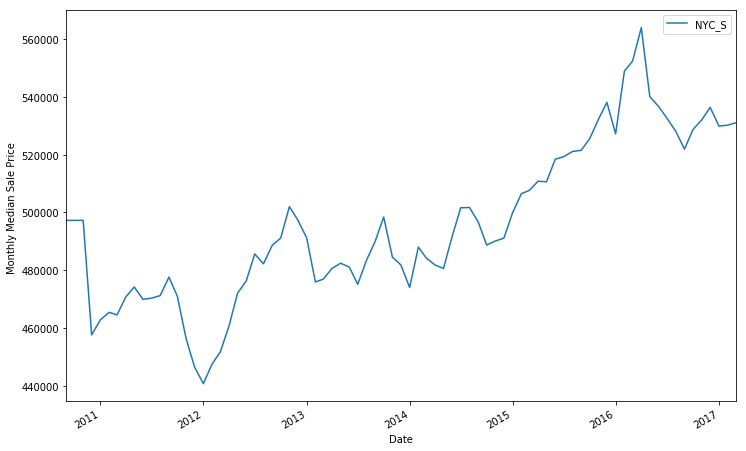

In [92]:
ax = df_ts_sale.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Sale Price ')
ax.set_xlabel('Date')

plt.show()

In [93]:
nycs_model = Prophet(interval_width=0.95)


In [94]:
df_ts_sale = df_ts_sale.rename(columns={'index': 'ds',
                        'NYC_S': 'y'})

df_ts_sale.head(5)

,y,ds
0,497241.772152,2010-09-01
1,497241.772152,2010-10-01
2,497241.772152,2010-11-01
3,457600.000000,2010-12-01
4,462800.000000,2011-01-01


In [95]:
nycs_model.fit(df_ts_sale)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [96]:
future_dates = nycs_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [97]:
forecast = nycs_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,571568.680009,497689.840438,654826.722245
138,2021-12-01,566301.715317,490946.875557,650856.598383
139,2022-01-01,561490.596896,485168.260876,644118.054226
140,2022-02-01,562717.743180,483238.783064,648027.292287
141,2022-03-01,566100.586709,485486.309170,657429.798361


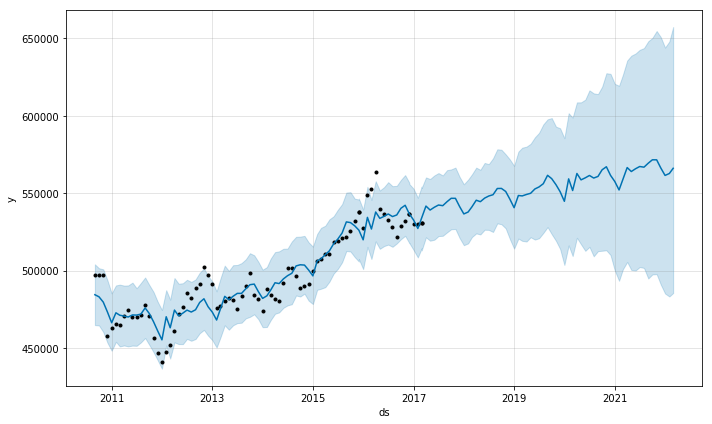

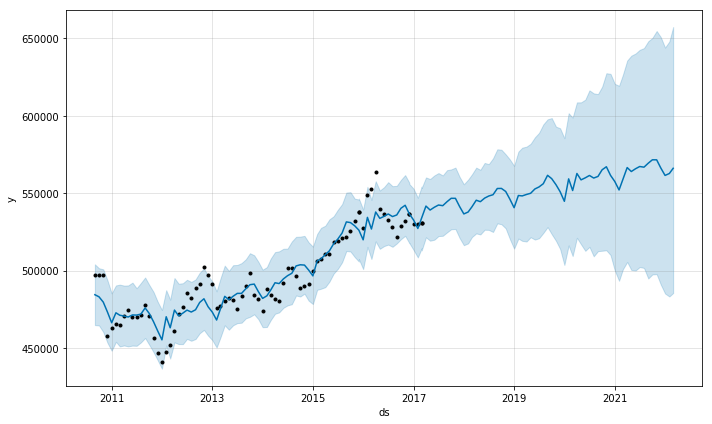

In [98]:
nycs_model.plot(forecast,
              uncertainty=True)

### Boston Sale projections:

In [99]:
df_bossale = df_final[['Boston_S', 'index']]

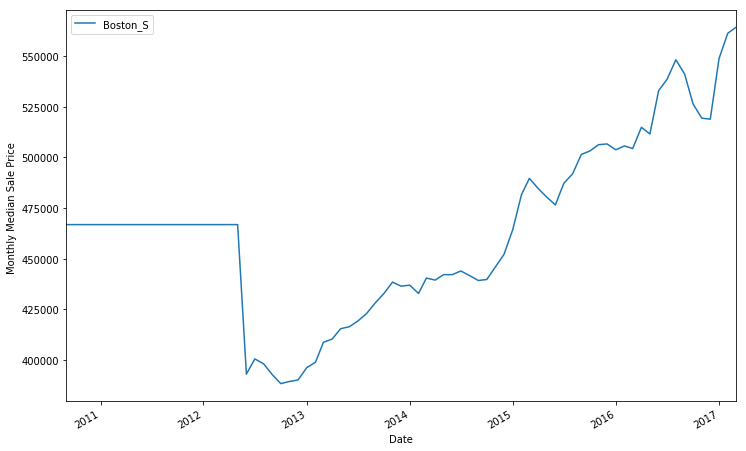

In [100]:
ax = df_bossale.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Sale Price ')
ax.set_xlabel('Date')

plt.show()

In [101]:
boss_model = Prophet(interval_width=0.95)


In [102]:
df_bossale = df_bossale.rename(columns={'index': 'ds',
                        'Boston_S': 'y'})

df_bossale.head(5)

,y,ds
0,466878.688525,2010-09-01
1,466878.688525,2010-10-01
2,466878.688525,2010-11-01
3,466878.688525,2010-12-01
4,466878.688525,2011-01-01


In [103]:
boss_model.fit(df_bossale)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [104]:
future_dates = boss_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [105]:
forecast = boss_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,734492.438943,561785.166625,896608.873786
138,2021-12-01,733662.221787,563514.562779,893305.266342
139,2022-01-01,746649.988542,569696.692103,907443.081188
140,2022-02-01,752012.772656,569643.513286,919953.670670
141,2022-03-01,758259.071859,564823.110507,929385.427448


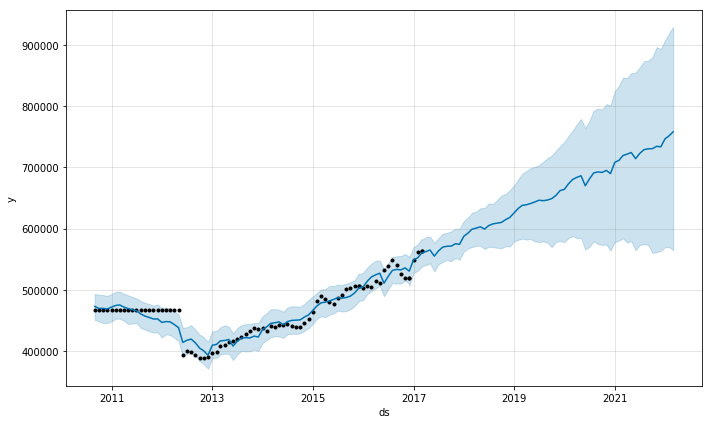

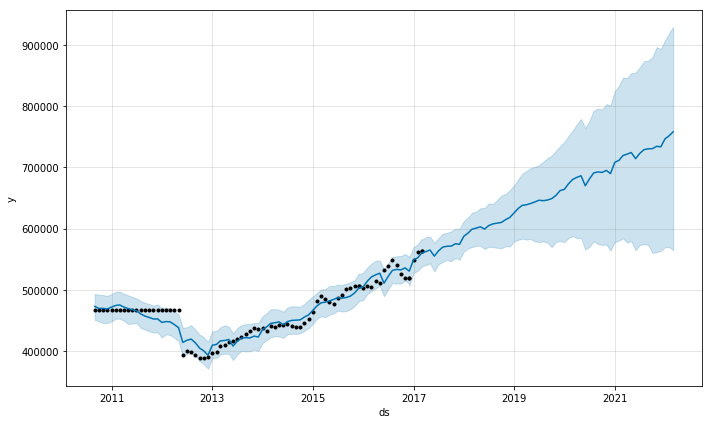

In [106]:
boss_model.plot(forecast,
              uncertainty=True)



In [107]:
#do a split here so that we can see how facebook works - how accurate it is.

### NYC Rental projections:

In [108]:
df_nycrent = df_final[['NYC_R', 'index']]

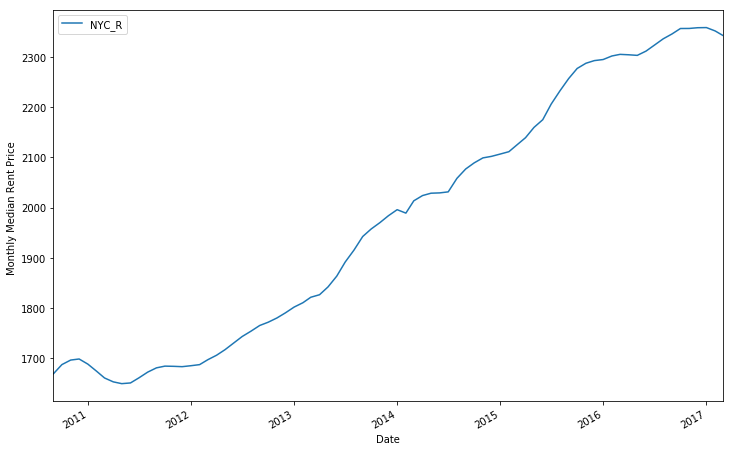

In [109]:
ax = df_nycrent.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Rent Price ')
ax.set_xlabel('Date')

plt.show()

In [110]:
nycr_model = Prophet(interval_width=0.95)


In [111]:
df_nycrent = df_nycrent.rename(columns={'index': 'ds',
                        'NYC_R': 'y'})

df_nycrent.head(5)

,y,ds
0,1668.64,2010-09-01
1,1686.88,2010-10-01
2,1695.90,2010-11-01
3,1698.04,2010-12-01
4,1687.80,2011-01-01


In [112]:
nycr_model.fit(df_nycrent)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [113]:
future_dates = nycr_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [114]:
forecast = nycr_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,2620.708086,1288.375304,3967.728415
138,2021-12-01,2620.163012,1259.572966,3982.959620
139,2022-01-01,2619.967045,1228.483846,4006.714065
140,2022-02-01,2614.096471,1182.261730,4025.776821
141,2022-03-01,2617.200850,1141.653670,4057.944432


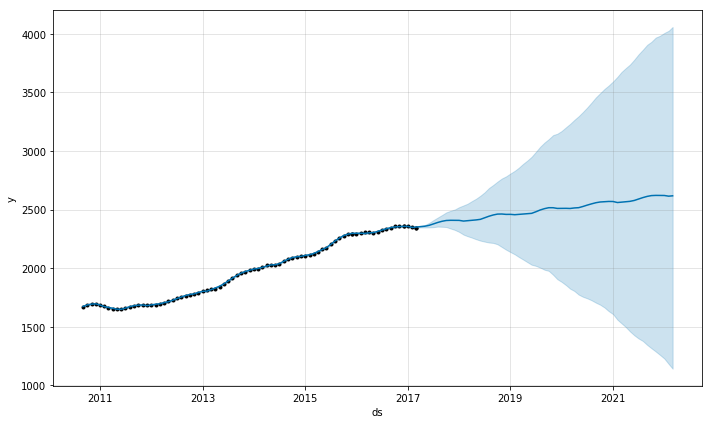

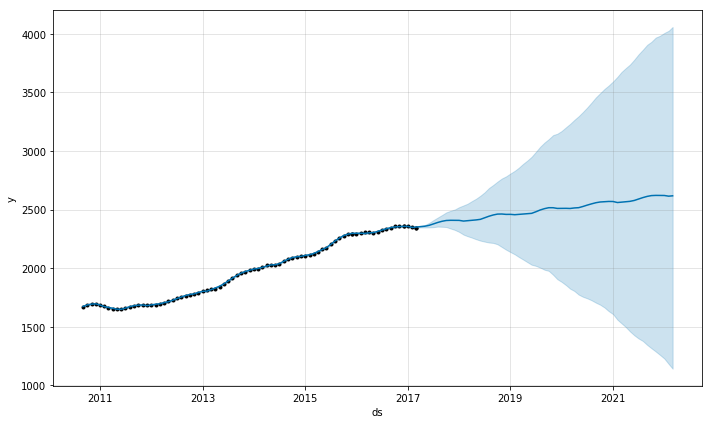

In [115]:
nycr_model.plot(forecast,
              uncertainty=True)

### Boston Rental projections:

In [116]:
df_bosrent = df_final[['Boston_R', 'index']]

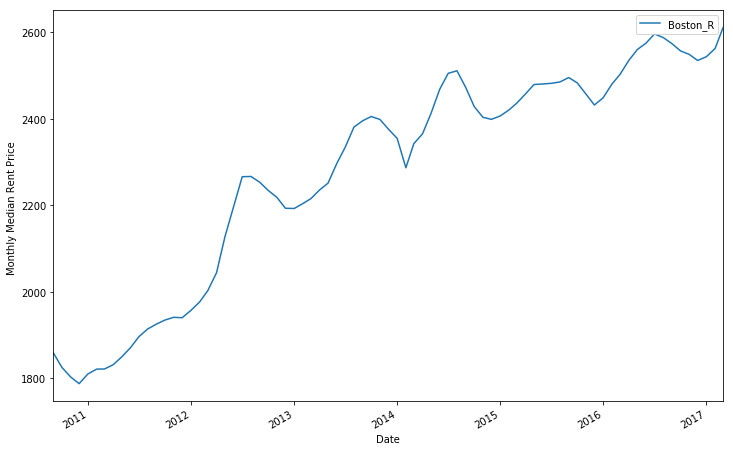

In [117]:
ax = df_bosrent.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Rent Price ')
ax.set_xlabel('Date')

plt.show()

In [118]:
bosr_model = Prophet(interval_width=0.95)


In [119]:
df_bosrent = df_bosrent.rename(columns={'index': 'ds',
                        'Boston_R': 'y'})

df_bosrent.head(5)

,y,ds
0,1857.87,2010-09-01
1,1824.65,2010-10-01
2,1802.43,2010-11-01
3,1787.04,2010-12-01
4,1809.40,2011-01-01


In [120]:
bosr_model.fit(df_bosrent)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [121]:
future_dates = bosr_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [122]:
forecast = bosr_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,3029.252346,2330.295422,3702.980502
138,2021-12-01,3009.112905,2297.705740,3715.617370
139,2022-01-01,3016.846802,2282.379353,3749.055436
140,2022-02-01,3017.838008,2257.791404,3755.744948
141,2022-03-01,3046.472759,2290.049768,3809.291254


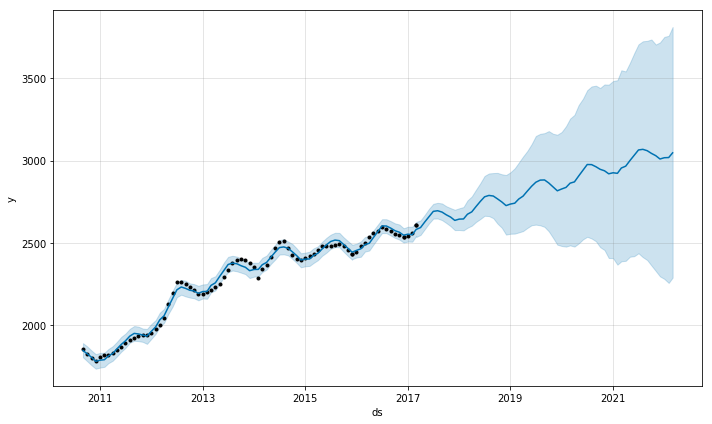

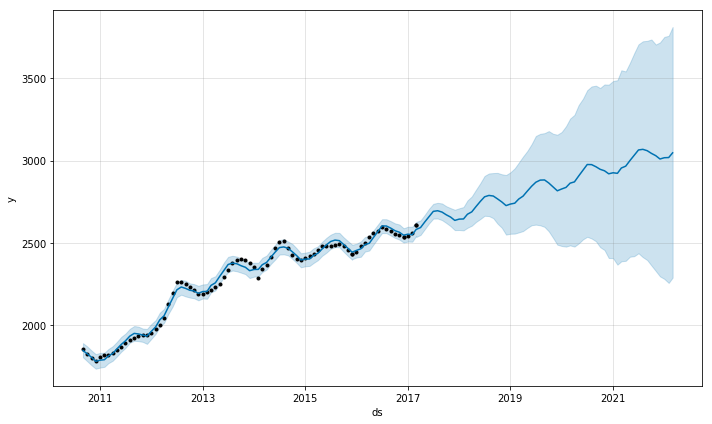

In [123]:
bosr_model.plot(forecast,
              uncertainty=True)

### Unemployment Rate projections:


In [124]:
unemployment_ = df_final[[ 'Unemployment Rate', 'index']]

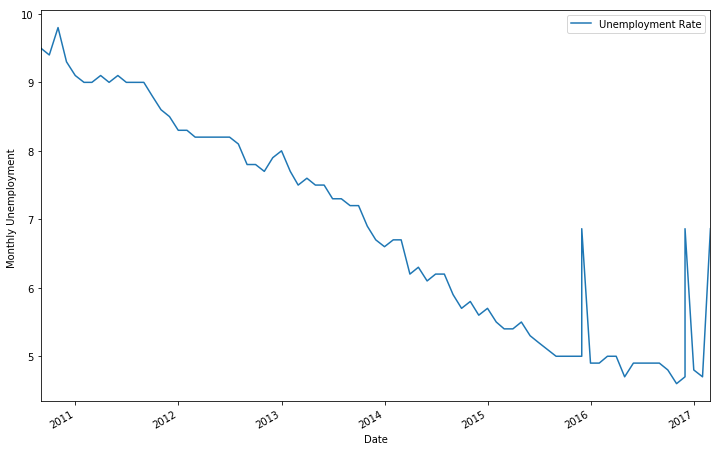

In [125]:
ax = unemployment_.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Unemployment ')
ax.set_xlabel('Date')

plt.show()

In [126]:
unemployment_model = Prophet(interval_width=0.95)

In [127]:
unemployment_ = unemployment_.rename(columns={'index': 'ds',
                        'Unemployment Rate': 'y'})

unemployment_.head(5)

,y,ds
0,9.5,2010-09-01
1,9.4,2010-10-01
2,9.8,2010-11-01
3,9.3,2010-12-01
4,9.1,2011-01-01


In [128]:
unemployment_model.fit(unemployment_)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [129]:
future_dates = unemployment_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [130]:
forecast = unemployment_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,4.476919,3.187701,5.705326
138,2021-12-01,4.874050,3.428761,6.281911
139,2022-01-01,4.486836,3.108541,5.712352
140,2022-02-01,4.410625,3.178636,5.723938
141,2022-03-01,4.891300,3.377856,6.164422


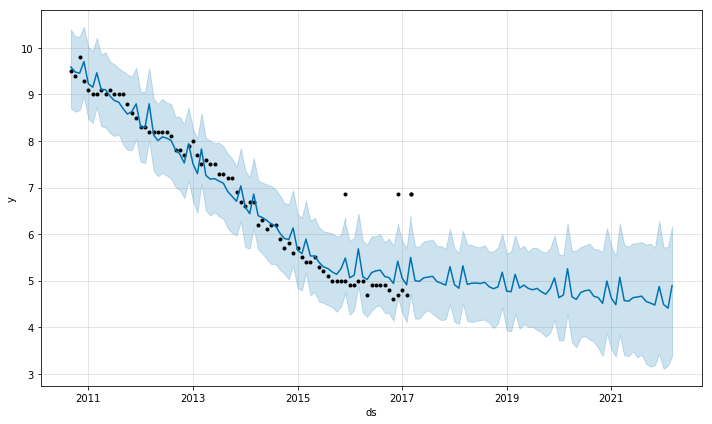

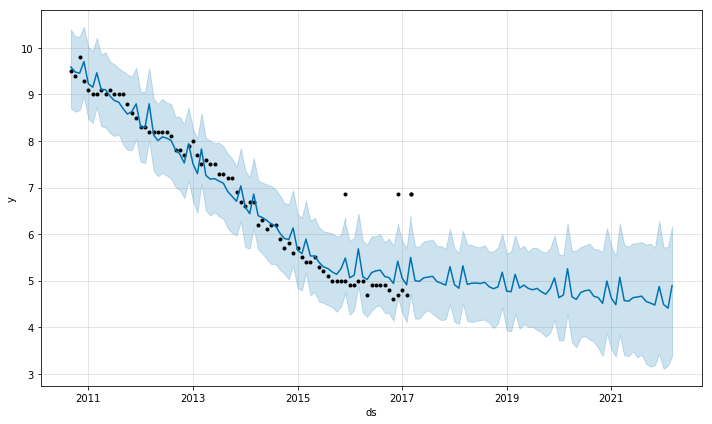

In [131]:
unemployment_model.plot(forecast,
              uncertainty=True)

### Interest Rate projections:

In [132]:
interestrate = df_final[[ 'Effective Federal Funds Rate', 'index']] 

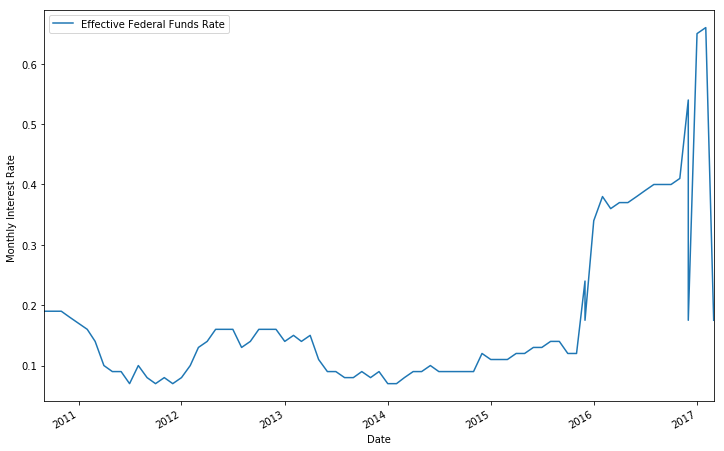

In [133]:
ax = interestrate.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Interest Rate ')
ax.set_xlabel('Date')

plt.show()

In [134]:
ir_model = Prophet(interval_width=0.95)

In [135]:
interestrate = interestrate.rename(columns={'index': 'ds',
                        'Effective Federal Funds Rate': 'y'})

interestrate.head(5)

,y,ds
0,0.19,2010-09-01
1,0.19,2010-10-01
2,0.19,2010-11-01
3,0.18,2010-12-01
4,0.17,2011-01-01


In [136]:
ir_model.fit(interestrate)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [137]:
future_dates = ir_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [138]:
forecast = ir_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,0.870416,0.679561,1.078026
138,2021-12-01,0.875070,0.675652,1.077165
139,2022-01-01,0.946892,0.741786,1.149845
140,2022-02-01,0.957357,0.751933,1.157842
141,2022-03-01,0.878754,0.665267,1.090631


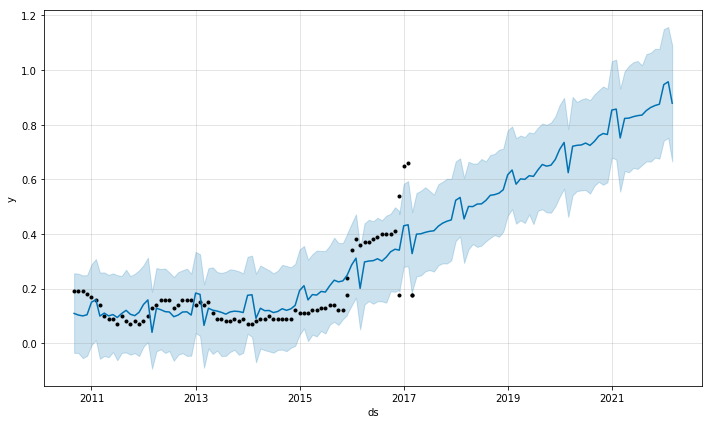

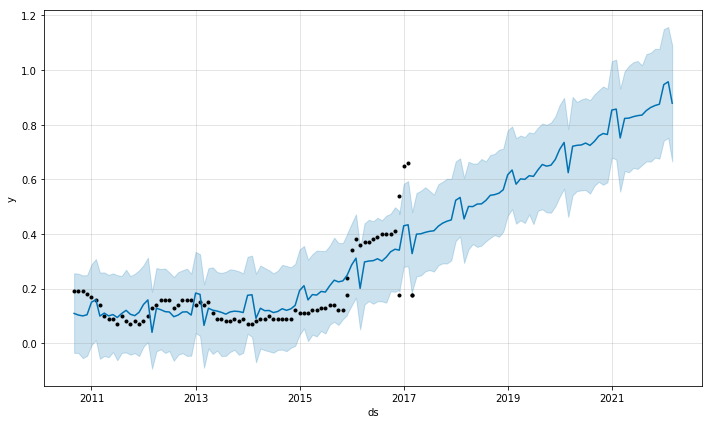

In [139]:
ir_model.plot(forecast,
              uncertainty=True)

# Demo section. Load the best model I have. Even if its OLS load prediction vs real one and show it

Bushwick 2 bed rental: https://www.zillow.com/homedetails/183-Stanhope-St-APT-1L-Brooklyn-NY-11237/2124261600_zpid/?

Bushwick 2 bed sale: https://www.zillow.com/homedetails/68-Garden-St-APT-7K-Brooklyn-NY-11206/2089555369_zpid/?


# Unsupervised Modeling! 

## Now we will use unsupervised models to try and help us find clusters of areas and times of the year that would be optimal for examinging in the potential years to come. 

### Let's create a couple of new columns labeled Month and Year so that we can use those features in our clustering.


In [140]:

X2 = df_final[[ 'Month', 'Year', 'MA_S', 'MA_R', 'MA_SqF', 'NY_days', 'MA_days', 'Boston_S', 'NYC_S', 'Boston_R', 'NYC_R']] 

## K means worked best for me when I was trying various clustering algorithms, so we be using K means for our unsupervised analysis:

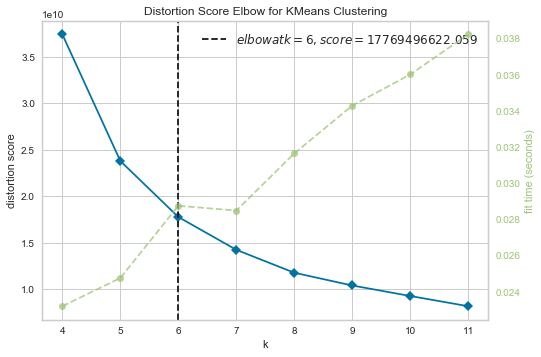

In [141]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
scaler = StandardScaler(X2)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X2)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [142]:
# Import KMeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters=6)

# Fit model to points
model.fit(X2)

# Determine the cluster labels of new_points: labels
labels = model.predict(X2)

# Print cluster labels of new_points
print(labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 1 1 1 1
 5 5 5 5 1 1 1 1]


In [143]:
df_final['Label'] = labels 
print (df_final['Label'])

0     2
1     2
2     2
3     2
4     2
     ..
77    5
78    1
79    1
80    1
81    1
Name: Label, Length: 82, dtype: int32


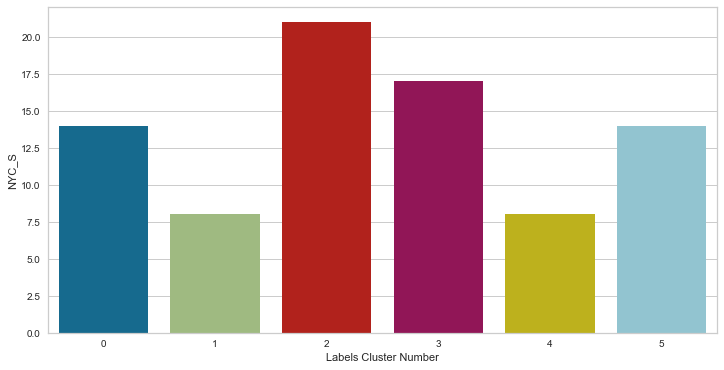

In [144]:

plt.figure(figsize=(12,6))
axis = sns.barplot(x= np.arange(0,6,1),y=df_final.groupby(['Label']).count()['NYC_S'].values)
x=axis.set_xlabel("Labels Cluster Number")
x=axis.set_ylabel("NYC_S")

In [145]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(X2, labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.5385432335593406


## Here I am creating a new df so that we can use the cluster labels in our analysis

In [146]:

X3 = df_final[['NY_S', 'Label', 'Month', 'Year', 'MA_S', 'NY_R', 'MA_R', 'NY_SqF', 'MA_SqF', 'NY_days', 'MA_days', 'Boston_S', 'NYC_S', 'Boston_R', 'NYC_R']] 



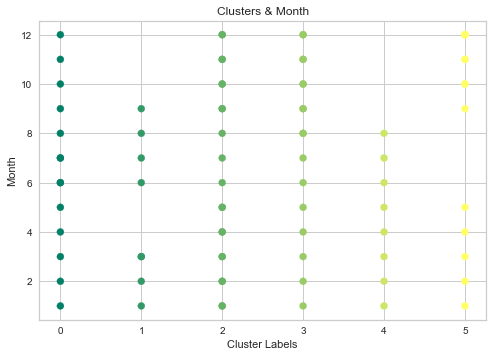

In [147]:
plt.scatter(X3['Label'], X3['Month'], c = labels, cmap = 'summer' )
plt.title("Clusters & Month")
plt.xlabel("Cluster Labels")
plt.ylabel("Month")
plt.show()

### Clustering is able to help us us groupings of certain months regarding the various cluster labels. Though we see a wide distribution among the various clusters, we do see that cluster 4 and 5 are limited in the number of months that are included in those clusters. This would indicate those cluster groupings might include average listings that are favor the spring and summer. 

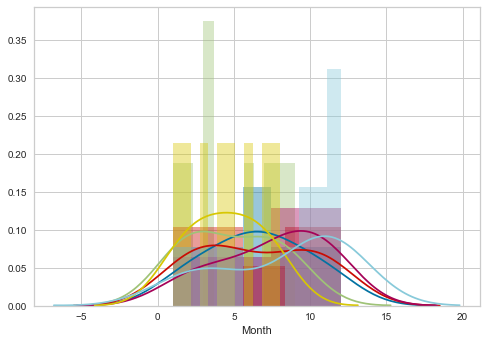

In [148]:


for i in range(7): 
    sns.distplot(df_final[df_final['Label'] == i]['Month'], bins=12)
    

In [149]:
df_final['Month'] = df_final['Month'].astype(str)

In [150]:
df_final[df_final['Label'] == 0]['Month'].astype(int).value_counts()

7     2
6     2
12    1
11    1
10    1
9     1
8     1
5     1
4     1
3     1
2     1
1     1
Name: Month, dtype: int64

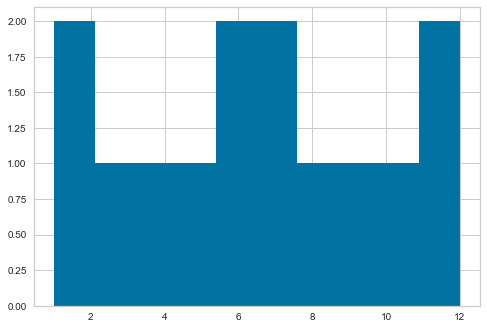

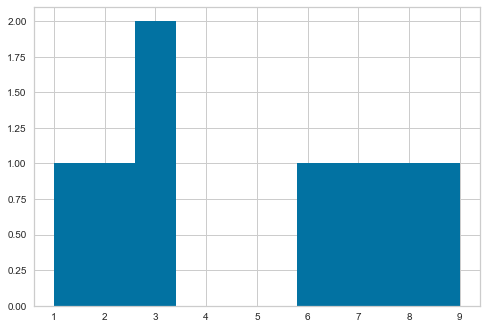

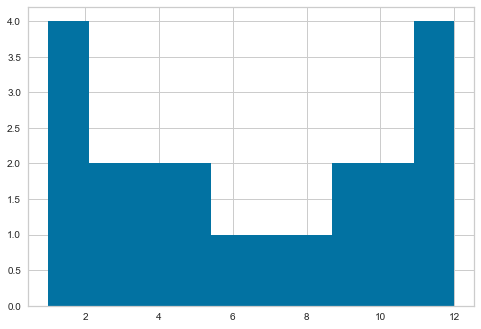

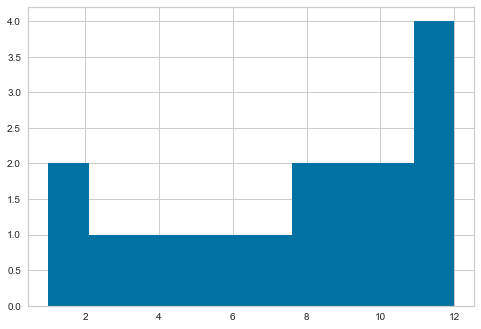

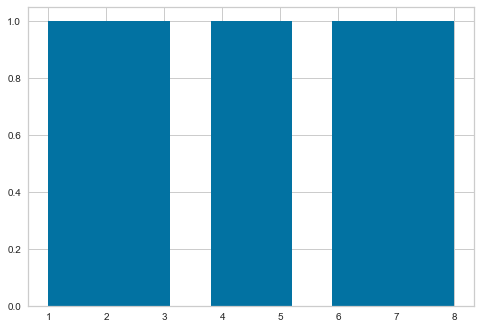

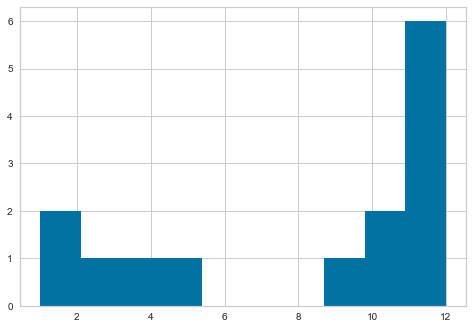

In [151]:
for i in range(6): 
    df_final[df_final['Label'] == i]['Month'].astype(int).hist()    
    plt.show()

In [152]:
plt.scatter(X3['Label'], X3['MA_SqF'], c = labels, cmap = 'summer' )
plt.title("Clusters & MA Price per Sq Footage")
plt.xlabel("Cluster Labels")
plt.ylabel("A Price per Sq Footage"F
plt.show()

SyntaxError: invalid syntax (<ipython-input-152-400efb9d7973>, line 4)

In [ ]:
plt.scatter(X3['Label'], X3['NY_SqF'], c = labels, cmap = 'summer' )
plt.title("Clusters & NY Price per Sq Footage")
plt.xlabel("Cluster Labels")
plt.ylabel("NY Price per Sq Footage")
plt.show()

### Here we also see cluster groupings which have square footage densities that favor certain clusters. For instance, cluster 1 and cluster 5 favor higher price per square footage in both MA and NY, while cluster 3 seems to include listings lower on that spectrum. Let's see if we see patterns between days on the market. 

In [ ]:
plt.scatter(X3['Label'], X3['NY_days'], c = labels, cmap = 'summer' )
plt.title("Clusters & NY Days on Market")
plt.xlabel("Cluster Labels")
plt.ylabel("NY Days on Market")
plt.show()

In [ ]:
plt.scatter(X3['Label'], X3['MA_days'], c = labels, cmap = 'summer' )
plt.title("Clusters & MA Days on Market")
plt.xlabel("Cluster Labels")
plt.ylabel("MA Days on Market")
plt.show()

### Here we can also see certain preferences between the clusters. Namely, cluster 2 contains the higher end of listings with a larger number of days on the market. Clusters 4 and 5 seem to have a lower number of instances with lower days on the market. 

# Let's now turn our attention to our original Y targets from our supervised learning portion: NYC and Boston sale and rent numbers for our last bit of insight regarding clusters.

In [ ]:
plt.scatter(X3['Label'], X3['NYC_S'], c = labels, cmap = 'summer' )
plt.title("Clusters & NYC Sale Market")
plt.xlabel("Cluster Labels")
plt.ylabel("NYC Sale Market")
plt.show()

In [ ]:
plt.scatter(X3['Label'], X3['NYC_R'], c = labels, cmap = 'summer' )
plt.title("Clusters & NYC Rental Market")
plt.xlabel("Cluster Labels")
plt.ylabel("NYC Rental Market")
plt.show()

### Regarding the NYC rent and sale market, clusters 1 and 5 include median values that are on the higher end of the spectrum and clusters 0 and 2 include median values that are on the lower end of the spectrum. We can pair this data with the days on the market and price per square footage data to come up with some cluster profiles.

In [ ]:
plt.scatter(X3['Label'], X3['Boston_S'], c = labels, cmap = 'summer' )
plt.title("Clusters & Boston Sale Market")
plt.xlabel("Cluster Labels")
plt.ylabel("Boston Sale Market")
plt.show()

In [ ]:
plt.scatter(X3['Label'], X3['Boston_R'], c = labels, cmap = 'summer' )
plt.title("Clusters & Boston Rental Market")
plt.xlabel("Cluster Labels")
plt.ylabel("Boston Rental Market")
plt.show()

### Regarding Boston rent and sale prices, cluster 1 and 5 also include the higher end of the spectrum, while clusters 0 and 2 include the lower end of the spectrum. We can pair this data with the days on the market and price per square footage data to come up with some cluster profiles.

## The clustering can help us with creating profiles on certain trends within the greater analysis of the Boston and NYC markets, while the regression models, along with prophet, can help us with being able to predict potential prices in the future. 

# A great next step from here would be to take a look and see where we can make greater efficiencies so that we can truly create a seamless recommender for folks looking to plan their future lives. Using machine learning to understand the market and where a market might be headed in the future is a great way to make data driven solutions for the future! 